In [39]:
with open('seeds.txt', 'r') as f:
    SEEDS = [int(line.strip()) for line in f.readlines()]
    
print("SEEDS:", SEEDS)

batch_sizes = [200, 500, 1000, 1500, 2000]

SEEDS: [42, 100, 1, 10, 20]


Loaded labeled CSV rows: 46564
Unique time_steps: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49)]
Label distribution:
 class
2.0    42019
1.0     4545
Name: count, dtype: int64

=== Run 1/5, Random State 42 ===

===== Warm-up stage: Isolation Forest =====
Warm-up selected 1600 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Expected Model Change

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 42] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 42] XGBoost_Model_02 illicit F1-score: 0.5773
[Run 42] XGBoost_Model_03 illicit F1-score: 0.6011
[Run 42] XGBoost_Model_04 illicit F1-score: 0.7140
[Run 42] XGBoost_Model_05 illicit F1-score: 0.7602
[Run 42] XGBoost_Model_06 illicit F1-score: 0.8008
[Run 42] XGBoost_Model_07 illicit F1-score: 0.8189
[Run 42] XGBoost_Model_08 illicit F1-score: 0.8166
[Run 42] XGBoost_Model_09 illicit F1-score: 0.8149
[Run 42] XGBoost_Model_10 illicit F1-score: 0.8010
[Run 42] XGBoost_Model_11 illicit F1-score: 0.8016
[Run 42] XGBoost_Model_12 illicit F1-score: 0.8196
[Run 42] XGBoost_Model_13 illicit F1-score: 0.8116
[Run 42] XGBoost_Model_14 illicit F1-score: 0.8163
[Run 42] XGBoost_Model_15 illicit F1-score: 0.8132
[Run 42] XGBoost_Model_16 illicit F1-score: 0.8182
[Run 42] XGBoost_Model_17 illicit F1-score: 0.8161
[Run 42] XGBoost_Model_18 illicit F1-score: 0.8157
[Run 42] XGBoost_Model_19 illicit F1-score: 0.8119
[Run 42] XGBoost_Model_20 illic

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


Warm-up selected 2400 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Expected Model Change =====
[Run 100] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 100] XGBoost_Model_02 illicit F1-score: 0.0055
[Run 100] XGBoost_Model_03 illicit F1-score: 0.0054
[Run 100] XGBoost_Model_04 illicit F1-score: 0.0430
[Run 100] XGBoost_Model_05 illicit F1-score: 0.7139
[Run 100] XGBoost_Model_06 illicit F1-score: 0.7524
[Run 100] XGBoost_Model_07 illicit F1-score: 0.7525
[Run 100] XGBoost_Model_08 illicit F1-score: 0.7659
[Run 100] XGBoost_Model_09 illicit F1-score: 0.7745
[Run 100] XGBoost_Model_10 illicit F1-score: 0.8084
[Run 100] XGBoost_Model_11 illicit F1-score: 0.8010
[Run 100] XGBoost_Model_12 illicit F1-score: 0.8105
[Run 100] XGBoost_Model_13 illicit F1-score: 0.7987
[Run 100] XGBoost_Model_14 illicit F1-score: 0.8194
[Run 100] XGBoost_Model_15 illicit F1-score: 0.8134
[Run 100] XGBoost_Model_16 illicit F1-score: 0.8137
[Run 100] XGBoost_Model_17 illicit F1-score: 0.

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)



===== Active Learning loop: Expected Model Change =====
[Run 1] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_02 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_03 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_04 illicit F1-score: 0.5460
[Run 1] XGBoost_Model_05 illicit F1-score: 0.7452
[Run 1] XGBoost_Model_06 illicit F1-score: 0.7736
[Run 1] XGBoost_Model_07 illicit F1-score: 0.7927
[Run 1] XGBoost_Model_08 illicit F1-score: 0.8115
[Run 1] XGBoost_Model_09 illicit F1-score: 0.8142
[Run 1] XGBoost_Model_10 illicit F1-score: 0.7873
[Run 1] XGBoost_Model_11 illicit F1-score: 0.8126
[Run 1] XGBoost_Model_12 illicit F1-score: 0.8134
[Run 1] XGBoost_Model_13 illicit F1-score: 0.8155
[Run 1] XGBoost_Model_14 illicit F1-score: 0.8186
[Run 1] XGBoost_Model_15 illicit F1-score: 0.8216
[Run 1] XGBoost_Model_16 illicit F1-score: 0.8178
[Run 1] XGBoost_Model_17 illicit F1-score: 0.8129
[Run 1] XGBoost_Model_18 illicit F1-score: 0.8154
[Run 1] XGBoost_Model_19 illicit F1-score: 

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 10] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 10] XGBoost_Model_02 illicit F1-score: 0.0018
[Run 10] XGBoost_Model_03 illicit F1-score: 0.7228
[Run 10] XGBoost_Model_04 illicit F1-score: 0.7511
[Run 10] XGBoost_Model_05 illicit F1-score: 0.7504
[Run 10] XGBoost_Model_06 illicit F1-score: 0.8031
[Run 10] XGBoost_Model_07 illicit F1-score: 0.8277
[Run 10] XGBoost_Model_08 illicit F1-score: 0.8072
[Run 10] XGBoost_Model_09 illicit F1-score: 0.8131
[Run 10] XGBoost_Model_10 illicit F1-score: 0.8168
[Run 10] XGBoost_Model_11 illicit F1-score: 0.8158
[Run 10] XGBoost_Model_12 illicit F1-score: 0.8155
[Run 10] XGBoost_Model_13 illicit F1-score: 0.8152
[Run 10] XGBoost_Model_14 illicit F1-score: 0.8194
[Run 10] XGBoost_Model_15 illicit F1-score: 0.8180
[Run 10] XGBoost_Model_16 illicit F1-score: 0.8109
[Run 10] XGBoost_Model_17 illicit F1-score: 0.8149
[Run 10] XGBoost_Model_18 illicit F1-score: 0.8182
[Run 10] XGBoost_Model_19 illicit F1-score: 0.8104
[Run 10] XGBoost_Model_20 illic

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


Warm-up selected 1400 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Expected Model Change =====
[Run 20] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 20] XGBoost_Model_02 illicit F1-score: 0.1179
[Run 20] XGBoost_Model_03 illicit F1-score: 0.6935
[Run 20] XGBoost_Model_04 illicit F1-score: 0.6791
[Run 20] XGBoost_Model_05 illicit F1-score: 0.7488
[Run 20] XGBoost_Model_06 illicit F1-score: 0.8154
[Run 20] XGBoost_Model_07 illicit F1-score: 0.8194
[Run 20] XGBoost_Model_08 illicit F1-score: 0.8067
[Run 20] XGBoost_Model_09 illicit F1-score: 0.8070
[Run 20] XGBoost_Model_10 illicit F1-score: 0.8195
[Run 20] XGBoost_Model_11 illicit F1-score: 0.8219
[Run 20] XGBoost_Model_12 illicit F1-score: 0.8203
[Run 20] XGBoost_Model_13 illicit F1-score: 0.8120
[Run 20] XGBoost_Model_14 illicit F1-score: 0.8102
[Run 20] XGBoost_Model_15 illicit F1-score: 0.8159
[Run 20] XGBoost_Model_16 illicit F1-score: 0.8138
[Run 20] XGBoost_Model_17 illicit F1-score: 0.8150
[Run 20] XGB

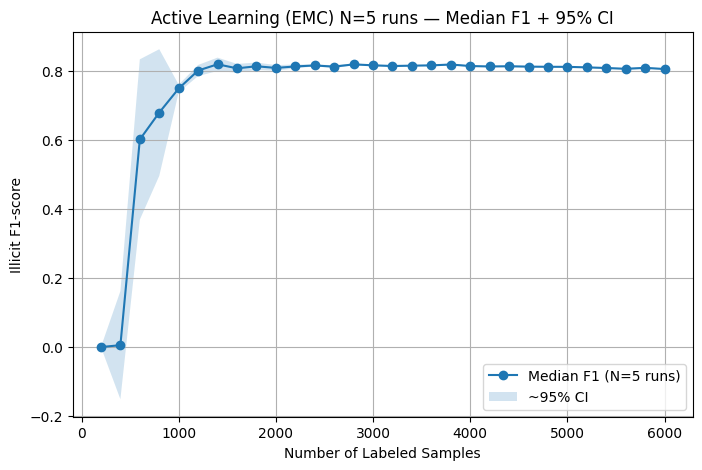


=== Run 1/5, Random State 42 ===

===== Warm-up stage: Isolation Forest =====
Warm-up selected 1500 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Expected Model Change =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 42] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 42] XGBoost_Model_02 illicit F1-score: 0.3756
[Run 42] XGBoost_Model_03 illicit F1-score: 0.7577
[Run 42] XGBoost_Model_04 illicit F1-score: 0.7515
[Run 42] XGBoost_Model_05 illicit F1-score: 0.8170
[Run 42] XGBoost_Model_06 illicit F1-score: 0.8218
[Run 42] XGBoost_Model_07 illicit F1-score: 0.8148
[Run 42] XGBoost_Model_08 illicit F1-score: 0.8106
[Run 42] XGBoost_Model_09 illicit F1-score: 0.8136
[Run 42] XGBoost_Model_10 illicit F1-score: 0.8135
[Run 42] XGBoost_Model_11 illicit F1-score: 0.8066
[Run 42] XGBoost_Model_12 illicit F1-score: 0.8093
[Run 42] XGBoost_Model_13 illicit F1-score: 0.8072
[Run 42] XGBoost_Model_14 illicit F1-score: 0.8076
[Run 42] XGBoost_Model_15 illicit F1-score: 0.8118
[Run 42] XGBoost_Model_16 illicit F1-score: 0.8054
[Run 42] XGBoost_Model_17 illicit F1-score: 0.8066
[Run 42] XGBoost_Model_18 illicit F1-score: 0.8095
[Run 42] XGBoost_Model_19 illicit F1-score: 0.8019
[Run 42] XGBoost_Model_20 illic

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)



===== Active Learning loop: Expected Model Change =====
[Run 100] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 100] XGBoost_Model_02 illicit F1-score: 0.5663
[Run 100] XGBoost_Model_03 illicit F1-score: 0.7646
[Run 100] XGBoost_Model_04 illicit F1-score: 0.8094
[Run 100] XGBoost_Model_05 illicit F1-score: 0.8029
[Run 100] XGBoost_Model_06 illicit F1-score: 0.8137
[Run 100] XGBoost_Model_07 illicit F1-score: 0.8125
[Run 100] XGBoost_Model_08 illicit F1-score: 0.8130
[Run 100] XGBoost_Model_09 illicit F1-score: 0.8156
[Run 100] XGBoost_Model_10 illicit F1-score: 0.8112
[Run 100] XGBoost_Model_11 illicit F1-score: 0.8108
[Run 100] XGBoost_Model_12 illicit F1-score: 0.8027
[Run 100] XGBoost_Model_13 illicit F1-score: 0.8062
[Run 100] XGBoost_Model_14 illicit F1-score: 0.8046
[Run 100] XGBoost_Model_15 illicit F1-score: 0.8029
[Run 100] XGBoost_Model_16 illicit F1-score: 0.8103
[Run 100] XGBoost_Model_17 illicit F1-score: 0.8047
[Run 100] XGBoost_Model_18 illicit F1-score: 0.8051
[Run 10

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 1] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_02 illicit F1-score: 0.0308
[Run 1] XGBoost_Model_03 illicit F1-score: 0.7423
[Run 1] XGBoost_Model_04 illicit F1-score: 0.8067
[Run 1] XGBoost_Model_05 illicit F1-score: 0.8233
[Run 1] XGBoost_Model_06 illicit F1-score: 0.8147
[Run 1] XGBoost_Model_07 illicit F1-score: 0.8166
[Run 1] XGBoost_Model_08 illicit F1-score: 0.8113
[Run 1] XGBoost_Model_09 illicit F1-score: 0.8113
[Run 1] XGBoost_Model_10 illicit F1-score: 0.8141
[Run 1] XGBoost_Model_11 illicit F1-score: 0.8117
[Run 1] XGBoost_Model_12 illicit F1-score: 0.8099
[Run 1] XGBoost_Model_13 illicit F1-score: 0.8058
[Run 1] XGBoost_Model_14 illicit F1-score: 0.8033
[Run 1] XGBoost_Model_15 illicit F1-score: 0.8075
[Run 1] XGBoost_Model_16 illicit F1-score: 0.8106
[Run 1] XGBoost_Model_17 illicit F1-score: 0.8035
[Run 1] XGBoost_Model_18 illicit F1-score: 0.8041
[Run 1] XGBoost_Model_19 illicit F1-score: 0.8056
[Run 1] XGBoost_Model_20 illicit F1-score: 0.8045


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 10] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 10] XGBoost_Model_02 illicit F1-score: 0.2885
[Run 10] XGBoost_Model_03 illicit F1-score: 0.7814
[Run 10] XGBoost_Model_04 illicit F1-score: 0.7916
[Run 10] XGBoost_Model_05 illicit F1-score: 0.7980
[Run 10] XGBoost_Model_06 illicit F1-score: 0.8138
[Run 10] XGBoost_Model_07 illicit F1-score: 0.8145
[Run 10] XGBoost_Model_08 illicit F1-score: 0.8198
[Run 10] XGBoost_Model_09 illicit F1-score: 0.8149
[Run 10] XGBoost_Model_10 illicit F1-score: 0.8158
[Run 10] XGBoost_Model_11 illicit F1-score: 0.8123
[Run 10] XGBoost_Model_12 illicit F1-score: 0.8085
[Run 10] XGBoost_Model_13 illicit F1-score: 0.8114
[Run 10] XGBoost_Model_14 illicit F1-score: 0.8027
[Run 10] XGBoost_Model_15 illicit F1-score: 0.8045
[Run 10] XGBoost_Model_16 illicit F1-score: 0.8027
[Run 10] XGBoost_Model_17 illicit F1-score: 0.8066
[Run 10] XGBoost_Model_18 illicit F1-score: 0.8018
[Run 10] XGBoost_Model_19 illicit F1-score: 0.8064
[Run 10] XGBoost_Model_20 illic

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)



===== Active Learning loop: Expected Model Change =====
[Run 20] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 20] XGBoost_Model_02 illicit F1-score: 0.5158
[Run 20] XGBoost_Model_03 illicit F1-score: 0.7754
[Run 20] XGBoost_Model_04 illicit F1-score: 0.8016
[Run 20] XGBoost_Model_05 illicit F1-score: 0.8077
[Run 20] XGBoost_Model_06 illicit F1-score: 0.8188
[Run 20] XGBoost_Model_07 illicit F1-score: 0.8167
[Run 20] XGBoost_Model_08 illicit F1-score: 0.8190
[Run 20] XGBoost_Model_09 illicit F1-score: 0.8131
[Run 20] XGBoost_Model_10 illicit F1-score: 0.8171
[Run 20] XGBoost_Model_11 illicit F1-score: 0.8082
[Run 20] XGBoost_Model_12 illicit F1-score: 0.8052
[Run 20] XGBoost_Model_13 illicit F1-score: 0.8060
[Run 20] XGBoost_Model_14 illicit F1-score: 0.8060
[Run 20] XGBoost_Model_15 illicit F1-score: 0.8058
[Run 20] XGBoost_Model_16 illicit F1-score: 0.8077
[Run 20] XGBoost_Model_17 illicit F1-score: 0.8041
[Run 20] XGBoost_Model_18 illicit F1-score: 0.8008
[Run 20] XGBoost_Model_19

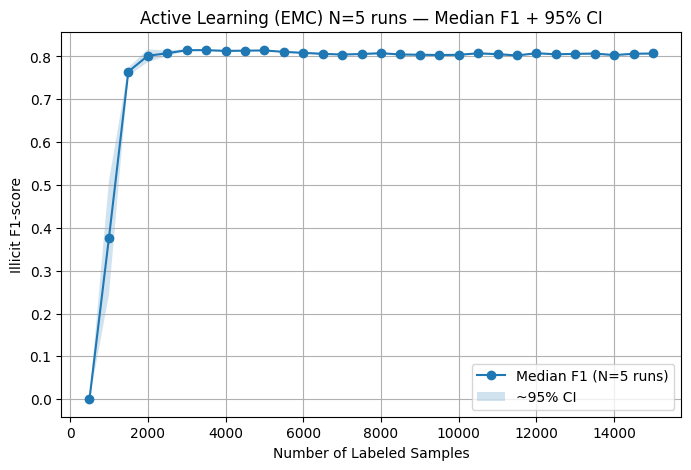


=== Run 1/5, Random State 42 ===

===== Warm-up stage: Isolation Forest =====
Warm-up selected 2000 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Expected Model Change =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 42] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 42] XGBoost_Model_02 illicit F1-score: 0.6178
[Run 42] XGBoost_Model_03 illicit F1-score: 0.7640
[Run 42] XGBoost_Model_04 illicit F1-score: 0.8072
[Run 42] XGBoost_Model_05 illicit F1-score: 0.8184
[Run 42] XGBoost_Model_06 illicit F1-score: 0.8119
[Run 42] XGBoost_Model_07 illicit F1-score: 0.8087
[Run 42] XGBoost_Model_08 illicit F1-score: 0.8072
[Run 42] XGBoost_Model_09 illicit F1-score: 0.8035
[Run 42] XGBoost_Model_10 illicit F1-score: 0.8095
[Run 42] XGBoost_Model_11 illicit F1-score: 0.8023
[Run 42] XGBoost_Model_12 illicit F1-score: 0.8070
[Run 42] XGBoost_Model_13 illicit F1-score: 0.8020
[Run 42] XGBoost_Model_14 illicit F1-score: 0.8093
[Run 42] XGBoost_Model_15 illicit F1-score: 0.8091
[Run 42] XGBoost_Model_16 illicit F1-score: 0.8078
[Run 42] XGBoost_Model_17 illicit F1-score: 0.8062
[Run 42] XGBoost_Model_18 illicit F1-score: 0.8072
[Run 42] XGBoost_Model_19 illicit F1-score: 0.8031
[Run 42] XGBoost_Model_20 illic

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


Warm-up selected 3000 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Expected Model Change =====
[Run 100] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 100] XGBoost_Model_02 illicit F1-score: 0.5659
[Run 100] XGBoost_Model_03 illicit F1-score: 0.7304
[Run 100] XGBoost_Model_04 illicit F1-score: 0.8070
[Run 100] XGBoost_Model_05 illicit F1-score: 0.8142
[Run 100] XGBoost_Model_06 illicit F1-score: 0.8104
[Run 100] XGBoost_Model_07 illicit F1-score: 0.8102
[Run 100] XGBoost_Model_08 illicit F1-score: 0.8129
[Run 100] XGBoost_Model_09 illicit F1-score: 0.8114
[Run 100] XGBoost_Model_10 illicit F1-score: 0.8101
[Run 100] XGBoost_Model_11 illicit F1-score: 0.8052
[Run 100] XGBoost_Model_12 illicit F1-score: 0.8110
[Run 100] XGBoost_Model_13 illicit F1-score: 0.8033
[Run 100] XGBoost_Model_14 illicit F1-score: 0.8095
[Run 100] XGBoost_Model_15 illicit F1-score: 0.8072
[Run 100] XGBoost_Model_16 illicit F1-score: 0.8033
[Run 100] XGBoost_Model_17 illicit F1-score: 0.

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)



===== Active Learning loop: Expected Model Change =====
[Run 1] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_02 illicit F1-score: 0.2624
[Run 1] XGBoost_Model_03 illicit F1-score: 0.7039
[Run 1] XGBoost_Model_04 illicit F1-score: 0.8159
[Run 1] XGBoost_Model_05 illicit F1-score: 0.8125
[Run 1] XGBoost_Model_06 illicit F1-score: 0.8087
[Run 1] XGBoost_Model_07 illicit F1-score: 0.8159
[Run 1] XGBoost_Model_08 illicit F1-score: 0.8064
[Run 1] XGBoost_Model_09 illicit F1-score: 0.8068
[Run 1] XGBoost_Model_10 illicit F1-score: 0.8084
[Run 1] XGBoost_Model_11 illicit F1-score: 0.8049
[Run 1] XGBoost_Model_12 illicit F1-score: 0.8080
[Run 1] XGBoost_Model_13 illicit F1-score: 0.8060
[Run 1] XGBoost_Model_14 illicit F1-score: 0.8051
[Run 1] XGBoost_Model_15 illicit F1-score: 0.8095
[Run 1] XGBoost_Model_16 illicit F1-score: 0.8060
[Run 1] XGBoost_Model_17 illicit F1-score: 0.8033
[Run 1] XGBoost_Model_18 illicit F1-score: 0.8027
[Run 1] XGBoost_Model_19 illicit F1-score: 

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


Warm-up selected 3000 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Expected Model Change =====
[Run 10] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 10] XGBoost_Model_02 illicit F1-score: 0.4723
[Run 10] XGBoost_Model_03 illicit F1-score: 0.7591
[Run 10] XGBoost_Model_04 illicit F1-score: 0.8045
[Run 10] XGBoost_Model_05 illicit F1-score: 0.8114
[Run 10] XGBoost_Model_06 illicit F1-score: 0.8114
[Run 10] XGBoost_Model_07 illicit F1-score: 0.8122
[Run 10] XGBoost_Model_08 illicit F1-score: 0.8021
[Run 10] XGBoost_Model_09 illicit F1-score: 0.8018
[Run 10] XGBoost_Model_10 illicit F1-score: 0.8074
[Run 10] XGBoost_Model_11 illicit F1-score: 0.8041
[Run 10] XGBoost_Model_12 illicit F1-score: 0.8006
[Run 10] XGBoost_Model_13 illicit F1-score: 0.8060
[Run 10] XGBoost_Model_14 illicit F1-score: 0.8004
[Run 10] XGBoost_Model_15 illicit F1-score: 0.8108
[Run 10] XGBoost_Model_16 illicit F1-score: 0.8070
[Run 10] XGBoost_Model_17 illicit F1-score: 0.8112
[Run 10] XGB

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 20] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 20] XGBoost_Model_02 illicit F1-score: 0.6756
[Run 20] XGBoost_Model_03 illicit F1-score: 0.8016
[Run 20] XGBoost_Model_04 illicit F1-score: 0.8118
[Run 20] XGBoost_Model_05 illicit F1-score: 0.8163
[Run 20] XGBoost_Model_06 illicit F1-score: 0.8150
[Run 20] XGBoost_Model_07 illicit F1-score: 0.8110
[Run 20] XGBoost_Model_08 illicit F1-score: 0.8110
[Run 20] XGBoost_Model_09 illicit F1-score: 0.8133
[Run 20] XGBoost_Model_10 illicit F1-score: 0.8064
[Run 20] XGBoost_Model_11 illicit F1-score: 0.8008
[Run 20] XGBoost_Model_12 illicit F1-score: 0.8023
[Run 20] XGBoost_Model_13 illicit F1-score: 0.8035
[Run 20] XGBoost_Model_14 illicit F1-score: 0.8074
[Run 20] XGBoost_Model_15 illicit F1-score: 0.8064
[Run 20] XGBoost_Model_16 illicit F1-score: 0.8095
[Run 20] XGBoost_Model_17 illicit F1-score: 0.8077
[Run 20] XGBoost_Model_18 illicit F1-score: 0.8018
[Run 20] XGBoost_Model_19 illicit F1-score: 0.8102
[Run 20] XGBoost_Model_20 illic

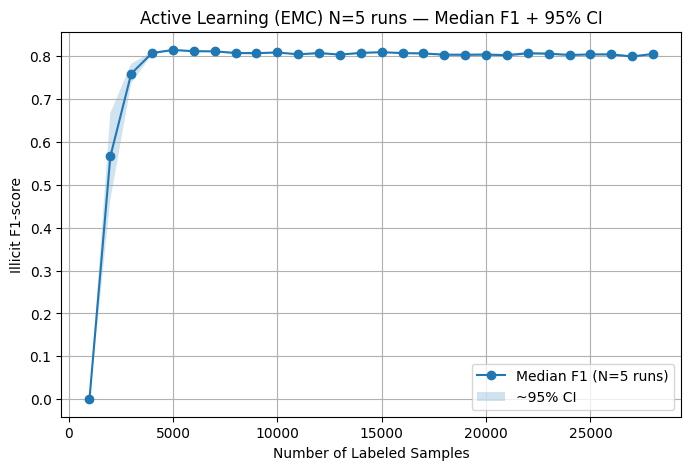


=== Run 1/5, Random State 42 ===

===== Warm-up stage: Isolation Forest =====
Warm-up selected 1500 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Expected Model Change =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 42] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 42] XGBoost_Model_02 illicit F1-score: 0.6726
[Run 42] XGBoost_Model_03 illicit F1-score: 0.7842
[Run 42] XGBoost_Model_04 illicit F1-score: 0.8035
[Run 42] XGBoost_Model_05 illicit F1-score: 0.8159
[Run 42] XGBoost_Model_06 illicit F1-score: 0.8145
[Run 42] XGBoost_Model_07 illicit F1-score: 0.8049
[Run 42] XGBoost_Model_08 illicit F1-score: 0.8132
[Run 42] XGBoost_Model_09 illicit F1-score: 0.8082
[Run 42] XGBoost_Model_10 illicit F1-score: 0.8111
[Run 42] XGBoost_Model_11 illicit F1-score: 0.8089
[Run 42] XGBoost_Model_12 illicit F1-score: 0.8039
[Run 42] XGBoost_Model_13 illicit F1-score: 0.8099
[Run 42] XGBoost_Model_14 illicit F1-score: 0.7992
[Run 42] XGBoost_Model_15 illicit F1-score: 0.8064
[Run 42] XGBoost_Model_16 illicit F1-score: 0.8004
[Run 42] XGBoost_Model_17 illicit F1-score: 0.8056
[Run 42] XGBoost_Model_18 illicit F1-score: 0.8025
[Run 42] XGBoost_Model_19 illicit F1-score: 0.8049

=== Run 2/5, Random State 100 

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 100] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 100] XGBoost_Model_02 illicit F1-score: 0.6445
[Run 100] XGBoost_Model_03 illicit F1-score: 0.8068
[Run 100] XGBoost_Model_04 illicit F1-score: 0.8097
[Run 100] XGBoost_Model_05 illicit F1-score: 0.8144
[Run 100] XGBoost_Model_06 illicit F1-score: 0.8092
[Run 100] XGBoost_Model_07 illicit F1-score: 0.8064
[Run 100] XGBoost_Model_08 illicit F1-score: 0.8058
[Run 100] XGBoost_Model_09 illicit F1-score: 0.8056
[Run 100] XGBoost_Model_10 illicit F1-score: 0.8054
[Run 100] XGBoost_Model_11 illicit F1-score: 0.8079
[Run 100] XGBoost_Model_12 illicit F1-score: 0.8045
[Run 100] XGBoost_Model_13 illicit F1-score: 0.8039
[Run 100] XGBoost_Model_14 illicit F1-score: 0.8070
[Run 100] XGBoost_Model_15 illicit F1-score: 0.8060
[Run 100] XGBoost_Model_16 illicit F1-score: 0.8049
[Run 100] XGBoost_Model_17 illicit F1-score: 0.8014
[Run 100] XGBoost_Model_18 illicit F1-score: 0.7992

=== Run 3/5, Random State 1 ===

===== Warm-up stage: Isolation

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 1] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_02 illicit F1-score: 0.5966
[Run 1] XGBoost_Model_03 illicit F1-score: 0.7921
[Run 1] XGBoost_Model_04 illicit F1-score: 0.8060
[Run 1] XGBoost_Model_05 illicit F1-score: 0.8079
[Run 1] XGBoost_Model_06 illicit F1-score: 0.8066
[Run 1] XGBoost_Model_07 illicit F1-score: 0.8072
[Run 1] XGBoost_Model_08 illicit F1-score: 0.8112
[Run 1] XGBoost_Model_09 illicit F1-score: 0.8025
[Run 1] XGBoost_Model_10 illicit F1-score: 0.8068
[Run 1] XGBoost_Model_11 illicit F1-score: 0.8066
[Run 1] XGBoost_Model_12 illicit F1-score: 0.8074
[Run 1] XGBoost_Model_13 illicit F1-score: 0.8016
[Run 1] XGBoost_Model_14 illicit F1-score: 0.8000
[Run 1] XGBoost_Model_15 illicit F1-score: 0.8062
[Run 1] XGBoost_Model_16 illicit F1-score: 0.8062
[Run 1] XGBoost_Model_17 illicit F1-score: 0.8016
[Run 1] XGBoost_Model_18 illicit F1-score: 0.8049

=== Run 4/5, Random State 10 ===

===== Warm-up stage: Isolation Forest =====
Warm-up selected 3000

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 10] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 10] XGBoost_Model_02 illicit F1-score: 0.4944
[Run 10] XGBoost_Model_03 illicit F1-score: 0.7884
[Run 10] XGBoost_Model_04 illicit F1-score: 0.8066
[Run 10] XGBoost_Model_05 illicit F1-score: 0.8080
[Run 10] XGBoost_Model_06 illicit F1-score: 0.8085
[Run 10] XGBoost_Model_07 illicit F1-score: 0.8037
[Run 10] XGBoost_Model_08 illicit F1-score: 0.8076
[Run 10] XGBoost_Model_09 illicit F1-score: 0.8118
[Run 10] XGBoost_Model_10 illicit F1-score: 0.8031
[Run 10] XGBoost_Model_11 illicit F1-score: 0.8062
[Run 10] XGBoost_Model_12 illicit F1-score: 0.8087
[Run 10] XGBoost_Model_13 illicit F1-score: 0.8068
[Run 10] XGBoost_Model_14 illicit F1-score: 0.8093
[Run 10] XGBoost_Model_15 illicit F1-score: 0.7967
[Run 10] XGBoost_Model_16 illicit F1-score: 0.8099
[Run 10] XGBoost_Model_17 illicit F1-score: 0.8070
[Run 10] XGBoost_Model_18 illicit F1-score: 0.8070

=== Run 5/5, Random State 20 ===

===== Warm-up stage: Isolation Forest =====
War

/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 20] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 20] XGBoost_Model_02 illicit F1-score: 0.6474
[Run 20] XGBoost_Model_03 illicit F1-score: 0.7794
[Run 20] XGBoost_Model_04 illicit F1-score: 0.8091
[Run 20] XGBoost_Model_05 illicit F1-score: 0.8148
[Run 20] XGBoost_Model_06 illicit F1-score: 0.8150
[Run 20] XGBoost_Model_07 illicit F1-score: 0.8021
[Run 20] XGBoost_Model_08 illicit F1-score: 0.8041
[Run 20] XGBoost_Model_09 illicit F1-score: 0.8082
[Run 20] XGBoost_Model_10 illicit F1-score: 0.8099
[Run 20] XGBoost_Model_11 illicit F1-score: 0.8062
[Run 20] XGBoost_Model_12 illicit F1-score: 0.8103
[Run 20] XGBoost_Model_13 illicit F1-score: 0.8041
[Run 20] XGBoost_Model_14 illicit F1-score: 0.8087
[Run 20] XGBoost_Model_15 illicit F1-score: 0.8029
[Run 20] XGBoost_Model_16 illicit F1-score: 0.8062
[Run 20] XGBoost_Model_17 illicit F1-score: 0.8068
[Run 20] XGBoost_Model_18 illicit F1-score: 0.8089
[Run 20] XGBoost_Model_19 illicit F1-score: 0.8014

===== Mean F1-score across 5 r

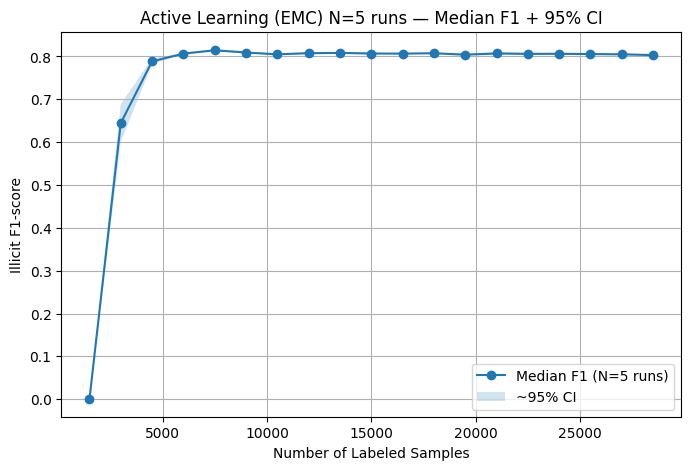


=== Run 1/5, Random State 42 ===

===== Warm-up stage: Isolation Forest =====
Warm-up selected 2000 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Expected Model Change =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 42] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 42] XGBoost_Model_02 illicit F1-score: 0.7199
[Run 42] XGBoost_Model_03 illicit F1-score: 0.8061
[Run 42] XGBoost_Model_04 illicit F1-score: 0.8083
[Run 42] XGBoost_Model_05 illicit F1-score: 0.8054
[Run 42] XGBoost_Model_06 illicit F1-score: 0.8091
[Run 42] XGBoost_Model_07 illicit F1-score: 0.8070
[Run 42] XGBoost_Model_08 illicit F1-score: 0.8020
[Run 42] XGBoost_Model_09 illicit F1-score: 0.8102
[Run 42] XGBoost_Model_10 illicit F1-score: 0.8087
[Run 42] XGBoost_Model_11 illicit F1-score: 0.8068
[Run 42] XGBoost_Model_12 illicit F1-score: 0.7998
[Run 42] XGBoost_Model_13 illicit F1-score: 0.8110
[Run 42] XGBoost_Model_14 illicit F1-score: 0.8043

=== Run 2/5, Random State 100 ===

===== Warm-up stage: Isolation Forest =====
Warm-up selected 4000 samples.
Warm-up found 2 illicit samples.

===== Active Learning loop: Expected Model Change =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 100] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 100] XGBoost_Model_02 illicit F1-score: 0.6261
[Run 100] XGBoost_Model_03 illicit F1-score: 0.7896
[Run 100] XGBoost_Model_04 illicit F1-score: 0.8146
[Run 100] XGBoost_Model_05 illicit F1-score: 0.8077
[Run 100] XGBoost_Model_06 illicit F1-score: 0.8122
[Run 100] XGBoost_Model_07 illicit F1-score: 0.8095
[Run 100] XGBoost_Model_08 illicit F1-score: 0.8076
[Run 100] XGBoost_Model_09 illicit F1-score: 0.8037
[Run 100] XGBoost_Model_10 illicit F1-score: 0.8064
[Run 100] XGBoost_Model_11 illicit F1-score: 0.8047
[Run 100] XGBoost_Model_12 illicit F1-score: 0.8055
[Run 100] XGBoost_Model_13 illicit F1-score: 0.7988

=== Run 3/5, Random State 1 ===

===== Warm-up stage: Isolation Forest =====
Warm-up selected 4000 samples.
Warm-up found 2 illicit samples.

===== Active Learning loop: Expected Model Change =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 1] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_02 illicit F1-score: 0.7630
[Run 1] XGBoost_Model_03 illicit F1-score: 0.8083
[Run 1] XGBoost_Model_04 illicit F1-score: 0.8175
[Run 1] XGBoost_Model_05 illicit F1-score: 0.8054
[Run 1] XGBoost_Model_06 illicit F1-score: 0.8139
[Run 1] XGBoost_Model_07 illicit F1-score: 0.8056
[Run 1] XGBoost_Model_08 illicit F1-score: 0.8137
[Run 1] XGBoost_Model_09 illicit F1-score: 0.8116
[Run 1] XGBoost_Model_10 illicit F1-score: 0.8016
[Run 1] XGBoost_Model_11 illicit F1-score: 0.8018
[Run 1] XGBoost_Model_12 illicit F1-score: 0.8111
[Run 1] XGBoost_Model_13 illicit F1-score: 0.7998

=== Run 4/5, Random State 10 ===

===== Warm-up stage: Isolation Forest =====
Warm-up selected 4000 samples.
Warm-up found 2 illicit samples.

===== Active Learning loop: Expected Model Change =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 10] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 10] XGBoost_Model_02 illicit F1-score: 0.6368
[Run 10] XGBoost_Model_03 illicit F1-score: 0.7792
[Run 10] XGBoost_Model_04 illicit F1-score: 0.8129
[Run 10] XGBoost_Model_05 illicit F1-score: 0.8104
[Run 10] XGBoost_Model_06 illicit F1-score: 0.8072
[Run 10] XGBoost_Model_07 illicit F1-score: 0.8062
[Run 10] XGBoost_Model_08 illicit F1-score: 0.8056
[Run 10] XGBoost_Model_09 illicit F1-score: 0.8070
[Run 10] XGBoost_Model_10 illicit F1-score: 0.8082
[Run 10] XGBoost_Model_11 illicit F1-score: 0.8062
[Run 10] XGBoost_Model_12 illicit F1-score: 0.8074
[Run 10] XGBoost_Model_13 illicit F1-score: 0.8006

=== Run 5/5, Random State 20 ===

===== Warm-up stage: Isolation Forest =====
Warm-up selected 2000 samples.
Warm-up found 2 illicit samples.

===== Active Learning loop: Expected Model Change =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/2180346055.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 20] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 20] XGBoost_Model_02 illicit F1-score: 0.7096
[Run 20] XGBoost_Model_03 illicit F1-score: 0.8072
[Run 20] XGBoost_Model_04 illicit F1-score: 0.8079
[Run 20] XGBoost_Model_05 illicit F1-score: 0.8114
[Run 20] XGBoost_Model_06 illicit F1-score: 0.8099
[Run 20] XGBoost_Model_07 illicit F1-score: 0.8118
[Run 20] XGBoost_Model_08 illicit F1-score: 0.8079
[Run 20] XGBoost_Model_09 illicit F1-score: 0.8093
[Run 20] XGBoost_Model_10 illicit F1-score: 0.8037
[Run 20] XGBoost_Model_11 illicit F1-score: 0.8066
[Run 20] XGBoost_Model_12 illicit F1-score: 0.8081
[Run 20] XGBoost_Model_13 illicit F1-score: 0.7992
[Run 20] XGBoost_Model_14 illicit F1-score: 0.8016

===== Mean F1-score across 5 runs per cycle =====
Cycle 01, Labeled 2000 samples: Mean F1 = 0.0000
Cycle 02, Labeled 4000 samples: Mean F1 = 0.6911
Cycle 03, Labeled 6000 samples: Mean F1 = 0.7981
Cycle 04, Labeled 8000 samples: Mean F1 = 0.8122
Cycle 05, Labeled 10000 samples: Mean F

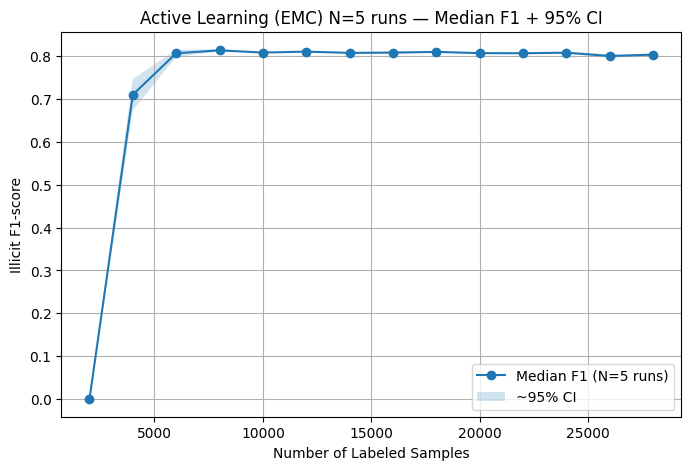


===== Batch Size Results Summary =====
Batch Size 200:
  Median F1: 0.8052
  95% CI: 0.0013
  Mean F1: 0.8054
Batch Size 500:
  Median F1: 0.8070
  95% CI: 0.0004
  Mean F1: 0.8069
Batch Size 1000:
  Median F1: 0.8050
  95% CI: 0.0009
  Mean F1: 0.8050
Batch Size 1500:
  Median F1: 0.8032
  95% CI: 0.0012
  Mean F1: 0.8032
Batch Size 2000:
  Median F1: 0.8030
  95% CI: 0.0009
  Mean F1: 0.8030


In [41]:
# This part should be invalid
# --- Active Learning: IF + EMC + XGBoost ---
# Paper reproduction version: N=5 runs, median F1 + 95% CI

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import xgboost as xgb
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Step 1: Load labeled data
labeled_df = pd.read_csv('data/elliptic_txs_features_labeled.csv')

# Check data
print("Loaded labeled CSV rows:", labeled_df.shape[0])
print("Unique time_steps:", sorted(labeled_df['time_step'].unique()))
print("Label distribution:\n", labeled_df['class'].value_counts())

# Step 2: Split train/test by time_step
train_df = labeled_df[labeled_df['time_step'] <= 34].reset_index(drop=True)
test_df  = labeled_df[labeled_df['time_step'] >= 35].reset_index(drop=True)

# Prepare test set
X_test = test_df.drop(columns=['txId', 'time_step', 'class'])
y_test = (test_df['class'] == 1).astype(int)

# Feature columns
feature_columns = [col for col in train_df.columns if col.startswith('feature_') or col.startswith('f')]

# Config
batch_size = 50
max_iterations = 30
N_runs = len(SEEDS)  # Number of runs based on seeds

# Storage for all runs
all_f1_scores = []

batch_size_scores = {}

# Step 3: Repeat N=5 runs
for batch_size in batch_sizes:
    all_f1_scores = []
    for run in range(N_runs):
        seed = SEEDS[run]
        print(f"\n==========================")
        print(f"=== Run {run+1}/{N_runs}, Random State {seed} ===")
        print("==========================")
        
        # Initialize pools
        unlabeled_pool = train_df.copy()
        labeled_pool = pd.DataFrame(columns=train_df.columns)
        f1_scores = []
        
        # Warm-up using Isolation Forest
        print("\n===== Warm-up stage: Isolation Forest =====")
        iso_forest = IsolationForest(random_state=seed)
        iso_forest.fit(unlabeled_pool[feature_columns])
        anomaly_scores = -iso_forest.score_samples(unlabeled_pool[feature_columns])
        unlabeled_pool['anomaly_score'] = anomaly_scores
        unlabeled_pool = unlabeled_pool.sort_values(by='anomaly_score', ascending=False).reset_index(drop=True)
        
        found_illicit = False
        pointer = 0
        warmup_illicit = 0
        
        while not found_illicit and pointer < len(unlabeled_pool):
            batch = unlabeled_pool.iloc[pointer:pointer+batch_size]
            labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)
            pointer += batch_size
            warmup_illicit = (labeled_pool['class'] == 1).sum()
            found_illicit = warmup_illicit > 0
        
        print(f"Warm-up selected {len(labeled_pool)} samples.")
        print(f"Warm-up found {warmup_illicit} illicit samples.")
        
        # Remove warm-up samples
        unlabeled_pool = unlabeled_pool.iloc[pointer:].drop(columns='anomaly_score').reset_index(drop=True)
        
        # Active Learning loop
        iteration = 1
        print("\n===== Active Learning loop: Expected Model Change =====")
        
        while len(unlabeled_pool) > 0 and iteration <= max_iterations:
            X_train = labeled_pool[feature_columns]
            y_train = (labeled_pool['class'] == 1).astype(int)
            
            xgb_clf = xgb.XGBClassifier(
                tree_method='hist',
                eval_metric='logloss',
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=seed
            )
            
            xgb_clf.fit(X_train, y_train)
            
            y_pred = xgb_clf.predict(X_test)
            f1 = f1_score(y_test, y_pred, pos_label=1)
            f1_scores.append(f1)
            print(f"[Run {seed}] XGBoost_Model_{iteration:02d} illicit F1-score: {f1:.4f}")
            
            # EMC sampling
            X_unlabeled = unlabeled_pool[feature_columns]
            proba = xgb_clf.predict_proba(X_unlabeled)[:, 1]
            emc_score = proba * (1 - proba)
            
            select_idx = np.argsort(-emc_score)[:batch_size]
            new_batch = unlabeled_pool.iloc[select_idx]
            
            labeled_pool = pd.concat([labeled_pool, new_batch], ignore_index=True)
            unlabeled_pool = unlabeled_pool.drop(unlabeled_pool.index[select_idx]).reset_index(drop=True)
            
            iteration += 1
        
        # Save F1-scores of this run
        all_f1_scores.append(f1_scores)

    # Step 4: Aggregate results — median + 95% CI
    # Pad runs with np.nan to same length
    max_len = max(len(scores) for scores in all_f1_scores)
    f1_matrix = np.full((N_runs, max_len), np.nan)
    for i, scores in enumerate(all_f1_scores):
        f1_matrix[i, :len(scores)] = scores

    # Median & CI
    median_f1 = np.nanmedian(f1_matrix, axis=0)
    std_f1 = np.nanstd(f1_matrix, axis=0)
    ci_95 = 1.57 * std_f1 / np.sqrt(N_runs)  # Approx 95% CI

    # --- Already computed:
    # f1_matrix = shape (5, N_iter)
    # median_f1 = np.nanmedian(f1_matrix, axis=0)

    # Print Mean F1-score per cycle (across 5 runs)
    mean_f1 = np.nanmean(f1_matrix, axis=0)

    print("\n===== Mean F1-score across 5 runs per cycle =====")
    for i, f1 in enumerate(mean_f1):
        print(f"Cycle {i+1:02d}, Labeled {(i+1)*batch_size} samples: Mean F1 = {f1:.4f}")

    # Step 6: Plot
    x_axis = np.arange(1, len(median_f1)+1) * batch_size

    plt.figure(figsize=(8, 5))
    plt.plot(x_axis, median_f1, marker='o', label='Median F1 (N=5 runs)')
    plt.fill_between(x_axis, median_f1 - ci_95, median_f1 + ci_95, alpha=0.2, label='~95% CI')
    plt.title("Active Learning (EMC) N=5 runs — Median F1 + 95% CI")
    plt.xlabel("Number of Labeled Samples")
    plt.ylabel("Illicit F1-score")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Store results for this batch size
    batch_size_scores[batch_size] = {
        'median_f1': median_f1,
        'ci_95': ci_95,
        'mean_f1': mean_f1
    }
    
print("\n===== Batch Size Results Summary =====")
for batch_size, scores in batch_size_scores.items():
    print(f"Batch Size {batch_size}:")
    print(f"  Median F1: {scores['median_f1'][-1]:.4f}")
    print(f"  95% CI: {scores['ci_95'][-1]:.4f}")
    print(f"  Mean F1: {scores['mean_f1'][-1]:.4f}")

In [48]:
# store results in json format
import json

with open('results.json', 'r') as f:
    json_input = json.load(f)

json_input["IF + EMC + XGBoost"] = {}

for k, v in batch_size_scores.items():
    json_input["IF + EMC + XGBoost"][str(k)] = v['mean_f1'][-1]

with open('results.json', 'w') as f:
    json.dump(json_input, f, indent=4)

Loaded labeled CSV rows: 46564
Unique time_steps: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49)]
Label distribution:
 class
2.0    42019
1.0     4545
Name: count, dtype: int64

=== Run 1/5, Random State 42

===== Warm-up stage: Isolation Forest =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


Warm-up selected 1600 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====
[Run 1] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_02 illicit F1-score: 0.5773
[Run 1] XGBoost_Model_03 illicit F1-score: 0.6011
[Run 1] XGBoost_Model_04 illicit F1-score: 0.7140
[Run 1] XGBoost_Model_05 illicit F1-score: 0.7602
[Run 1] XGBoost_Model_06 illicit F1-score: 0.8008
[Run 1] XGBoost_Model_07 illicit F1-score: 0.8189
[Run 1] XGBoost_Model_08 illicit F1-score: 0.8166
[Run 1] XGBoost_Model_09 illicit F1-score: 0.8149
[Run 1] XGBoost_Model_10 illicit F1-score: 0.8010
[Run 1] XGBoost_Model_11 illicit F1-score: 0.8016
[Run 1] XGBoost_Model_12 illicit F1-score: 0.8196
[Run 1] XGBoost_Model_13 illicit F1-score: 0.8116
[Run 1] XGBoost_Model_14 illicit F1-score: 0.8163
[Run 1] XGBoost_Model_15 illicit F1-score: 0.8132
[Run 1] XGBoost_Model_16 illicit F1-score: 0.8182
[Run 1] XGBoost_Model_17 illicit F1-score: 0.8161
[Run 1] XGBoost_Model_18 illic

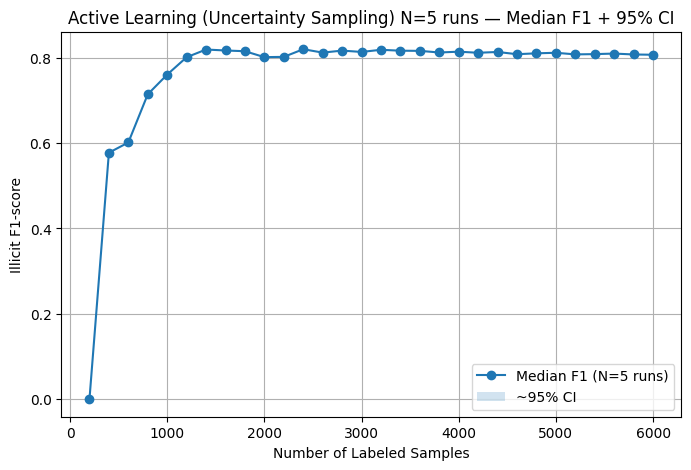


=== Run 2/5, Random State 100

===== Warm-up stage: Isolation Forest =====
Warm-up selected 2400 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 2] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 2] XGBoost_Model_02 illicit F1-score: 0.0055
[Run 2] XGBoost_Model_03 illicit F1-score: 0.0054
[Run 2] XGBoost_Model_04 illicit F1-score: 0.0430
[Run 2] XGBoost_Model_05 illicit F1-score: 0.7150
[Run 2] XGBoost_Model_06 illicit F1-score: 0.7552
[Run 2] XGBoost_Model_07 illicit F1-score: 0.6933
[Run 2] XGBoost_Model_08 illicit F1-score: 0.7821
[Run 2] XGBoost_Model_09 illicit F1-score: 0.7611
[Run 2] XGBoost_Model_10 illicit F1-score: 0.8046
[Run 2] XGBoost_Model_11 illicit F1-score: 0.8176
[Run 2] XGBoost_Model_12 illicit F1-score: 0.8085
[Run 2] XGBoost_Model_13 illicit F1-score: 0.7958
[Run 2] XGBoost_Model_14 illicit F1-score: 0.7731
[Run 2] XGBoost_Model_15 illicit F1-score: 0.8115
[Run 2] XGBoost_Model_16 illicit F1-score: 0.8111
[Run 2] XGBoost_Model_17 illicit F1-score: 0.8076
[Run 2] XGBoost_Model_18 illicit F1-score: 0.8112
[Run 2] XGBoost_Model_19 illicit F1-score: 0.8181
[Run 2] XGBoost_Model_20 illicit F1-score: 0.8092


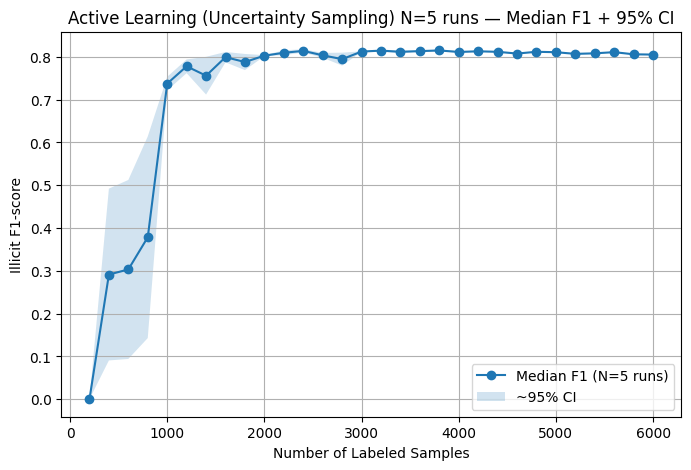


=== Run 3/5, Random State 1

===== Warm-up stage: Isolation Forest =====
Warm-up selected 2200 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 3] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 3] XGBoost_Model_02 illicit F1-score: 0.0000
[Run 3] XGBoost_Model_03 illicit F1-score: 0.0000
[Run 3] XGBoost_Model_04 illicit F1-score: 0.5460
[Run 3] XGBoost_Model_05 illicit F1-score: 0.7452
[Run 3] XGBoost_Model_06 illicit F1-score: 0.7736
[Run 3] XGBoost_Model_07 illicit F1-score: 0.7927
[Run 3] XGBoost_Model_08 illicit F1-score: 0.8115
[Run 3] XGBoost_Model_09 illicit F1-score: 0.8142
[Run 3] XGBoost_Model_10 illicit F1-score: 0.7873
[Run 3] XGBoost_Model_11 illicit F1-score: 0.8126
[Run 3] XGBoost_Model_12 illicit F1-score: 0.8134
[Run 3] XGBoost_Model_13 illicit F1-score: 0.8155
[Run 3] XGBoost_Model_14 illicit F1-score: 0.8186
[Run 3] XGBoost_Model_15 illicit F1-score: 0.8216
[Run 3] XGBoost_Model_16 illicit F1-score: 0.8178
[Run 3] XGBoost_Model_17 illicit F1-score: 0.8129
[Run 3] XGBoost_Model_18 illicit F1-score: 0.8154
[Run 3] XGBoost_Model_19 illicit F1-score: 0.8196
[Run 3] XGBoost_Model_20 illicit F1-score: 0.8180


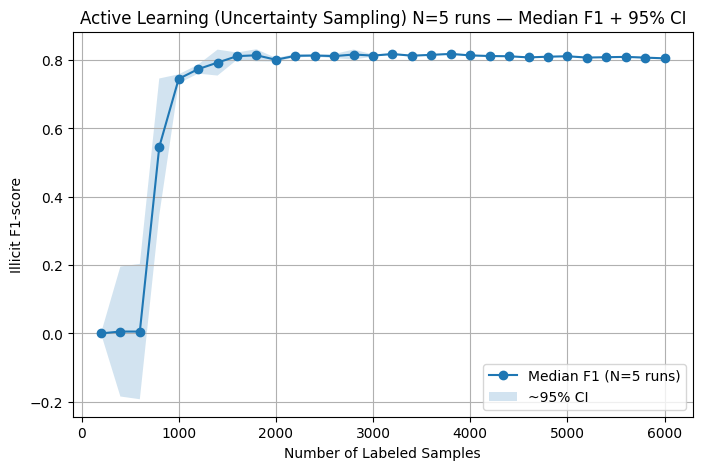


=== Run 4/5, Random State 10

===== Warm-up stage: Isolation Forest =====
Warm-up selected 2600 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 4] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 4] XGBoost_Model_02 illicit F1-score: 0.0018
[Run 4] XGBoost_Model_03 illicit F1-score: 0.7228
[Run 4] XGBoost_Model_04 illicit F1-score: 0.7511
[Run 4] XGBoost_Model_05 illicit F1-score: 0.7504
[Run 4] XGBoost_Model_06 illicit F1-score: 0.8031
[Run 4] XGBoost_Model_07 illicit F1-score: 0.8277
[Run 4] XGBoost_Model_08 illicit F1-score: 0.8072
[Run 4] XGBoost_Model_09 illicit F1-score: 0.8131
[Run 4] XGBoost_Model_10 illicit F1-score: 0.8168
[Run 4] XGBoost_Model_11 illicit F1-score: 0.8158
[Run 4] XGBoost_Model_12 illicit F1-score: 0.8155
[Run 4] XGBoost_Model_13 illicit F1-score: 0.8152
[Run 4] XGBoost_Model_14 illicit F1-score: 0.8194
[Run 4] XGBoost_Model_15 illicit F1-score: 0.8180
[Run 4] XGBoost_Model_16 illicit F1-score: 0.8109
[Run 4] XGBoost_Model_17 illicit F1-score: 0.8149
[Run 4] XGBoost_Model_18 illicit F1-score: 0.8182
[Run 4] XGBoost_Model_19 illicit F1-score: 0.8104
[Run 4] XGBoost_Model_20 illicit F1-score: 0.8177


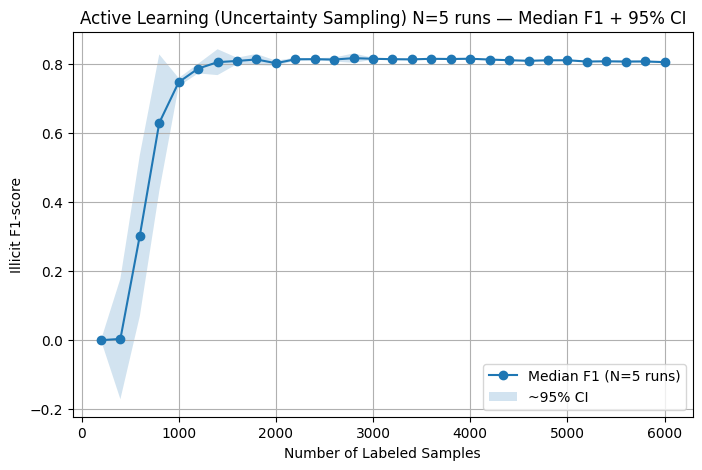


=== Run 5/5, Random State 20

===== Warm-up stage: Isolation Forest =====
Warm-up selected 1400 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 5] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 5] XGBoost_Model_02 illicit F1-score: 0.1179
[Run 5] XGBoost_Model_03 illicit F1-score: 0.6935
[Run 5] XGBoost_Model_04 illicit F1-score: 0.6791
[Run 5] XGBoost_Model_05 illicit F1-score: 0.7488
[Run 5] XGBoost_Model_06 illicit F1-score: 0.8154
[Run 5] XGBoost_Model_07 illicit F1-score: 0.8194
[Run 5] XGBoost_Model_08 illicit F1-score: 0.8067
[Run 5] XGBoost_Model_09 illicit F1-score: 0.8070
[Run 5] XGBoost_Model_10 illicit F1-score: 0.8195
[Run 5] XGBoost_Model_11 illicit F1-score: 0.8219
[Run 5] XGBoost_Model_12 illicit F1-score: 0.8203
[Run 5] XGBoost_Model_13 illicit F1-score: 0.8120
[Run 5] XGBoost_Model_14 illicit F1-score: 0.8102
[Run 5] XGBoost_Model_15 illicit F1-score: 0.8159
[Run 5] XGBoost_Model_16 illicit F1-score: 0.8138
[Run 5] XGBoost_Model_17 illicit F1-score: 0.8150
[Run 5] XGBoost_Model_18 illicit F1-score: 0.8098
[Run 5] XGBoost_Model_19 illicit F1-score: 0.8182
[Run 5] XGBoost_Model_20 illicit F1-score: 0.8138


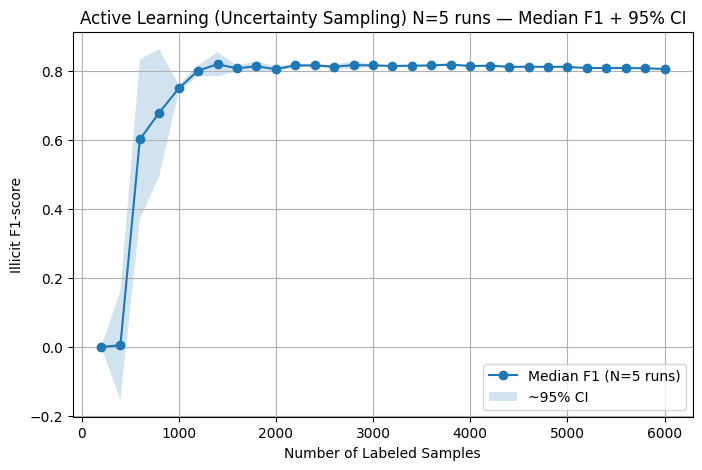


=== Run 1/5, Random State 42

===== Warm-up stage: Isolation Forest =====
Warm-up selected 1500 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 1] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_02 illicit F1-score: 0.3756
[Run 1] XGBoost_Model_03 illicit F1-score: 0.7577
[Run 1] XGBoost_Model_04 illicit F1-score: 0.7515
[Run 1] XGBoost_Model_05 illicit F1-score: 0.8170
[Run 1] XGBoost_Model_06 illicit F1-score: 0.8218
[Run 1] XGBoost_Model_07 illicit F1-score: 0.8148
[Run 1] XGBoost_Model_08 illicit F1-score: 0.8106
[Run 1] XGBoost_Model_09 illicit F1-score: 0.8136
[Run 1] XGBoost_Model_10 illicit F1-score: 0.8135
[Run 1] XGBoost_Model_11 illicit F1-score: 0.8066
[Run 1] XGBoost_Model_12 illicit F1-score: 0.8093
[Run 1] XGBoost_Model_13 illicit F1-score: 0.8072
[Run 1] XGBoost_Model_14 illicit F1-score: 0.8076
[Run 1] XGBoost_Model_15 illicit F1-score: 0.8060
[Run 1] XGBoost_Model_16 illicit F1-score: 0.8129
[Run 1] XGBoost_Model_17 illicit F1-score: 0.8066
[Run 1] XGBoost_Model_18 illicit F1-score: 0.8047
[Run 1] XGBoost_Model_19 illicit F1-score: 0.8062
[Run 1] XGBoost_Model_20 illicit F1-score: 0.8072


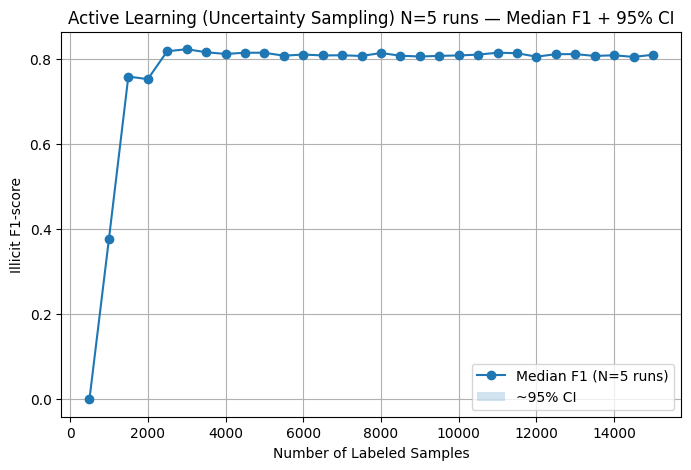


=== Run 2/5, Random State 100

===== Warm-up stage: Isolation Forest =====
Warm-up selected 2500 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 2] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 2] XGBoost_Model_02 illicit F1-score: 0.5663
[Run 2] XGBoost_Model_03 illicit F1-score: 0.7646
[Run 2] XGBoost_Model_04 illicit F1-score: 0.8094
[Run 2] XGBoost_Model_05 illicit F1-score: 0.8029
[Run 2] XGBoost_Model_06 illicit F1-score: 0.8137
[Run 2] XGBoost_Model_07 illicit F1-score: 0.8125
[Run 2] XGBoost_Model_08 illicit F1-score: 0.8130
[Run 2] XGBoost_Model_09 illicit F1-score: 0.8156
[Run 2] XGBoost_Model_10 illicit F1-score: 0.8112
[Run 2] XGBoost_Model_11 illicit F1-score: 0.8108
[Run 2] XGBoost_Model_12 illicit F1-score: 0.8027
[Run 2] XGBoost_Model_13 illicit F1-score: 0.8012
[Run 2] XGBoost_Model_14 illicit F1-score: 0.8035
[Run 2] XGBoost_Model_15 illicit F1-score: 0.8066
[Run 2] XGBoost_Model_16 illicit F1-score: 0.8023
[Run 2] XGBoost_Model_17 illicit F1-score: 0.8010
[Run 2] XGBoost_Model_18 illicit F1-score: 0.8041
[Run 2] XGBoost_Model_19 illicit F1-score: 0.8062
[Run 2] XGBoost_Model_20 illicit F1-score: 0.8037


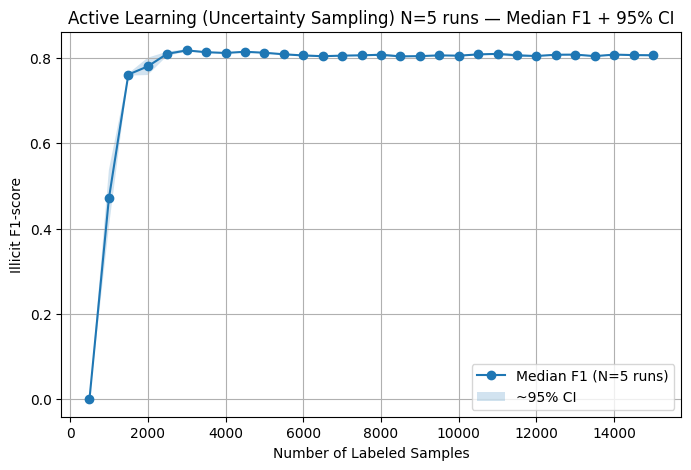


=== Run 3/5, Random State 1

===== Warm-up stage: Isolation Forest =====
Warm-up selected 2500 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 3] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 3] XGBoost_Model_02 illicit F1-score: 0.0308
[Run 3] XGBoost_Model_03 illicit F1-score: 0.7423
[Run 3] XGBoost_Model_04 illicit F1-score: 0.8067
[Run 3] XGBoost_Model_05 illicit F1-score: 0.8233
[Run 3] XGBoost_Model_06 illicit F1-score: 0.8147
[Run 3] XGBoost_Model_07 illicit F1-score: 0.8166
[Run 3] XGBoost_Model_08 illicit F1-score: 0.8113
[Run 3] XGBoost_Model_09 illicit F1-score: 0.8113
[Run 3] XGBoost_Model_10 illicit F1-score: 0.8141
[Run 3] XGBoost_Model_11 illicit F1-score: 0.8117
[Run 3] XGBoost_Model_12 illicit F1-score: 0.8099
[Run 3] XGBoost_Model_13 illicit F1-score: 0.8058
[Run 3] XGBoost_Model_14 illicit F1-score: 0.8033
[Run 3] XGBoost_Model_15 illicit F1-score: 0.8075
[Run 3] XGBoost_Model_16 illicit F1-score: 0.8106
[Run 3] XGBoost_Model_17 illicit F1-score: 0.8035
[Run 3] XGBoost_Model_18 illicit F1-score: 0.8041
[Run 3] XGBoost_Model_19 illicit F1-score: 0.8056
[Run 3] XGBoost_Model_20 illicit F1-score: 0.8045


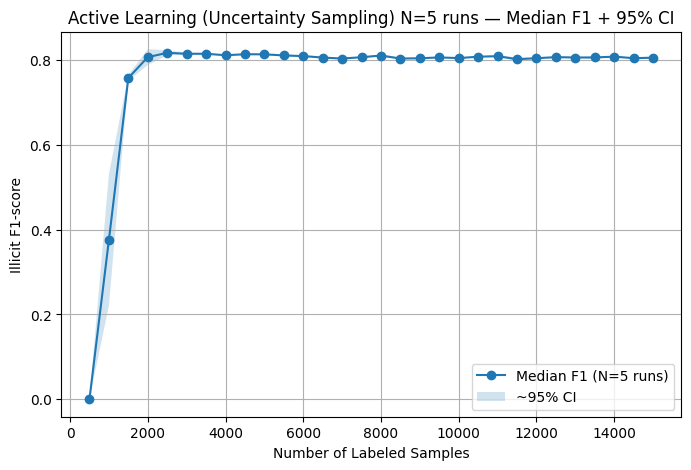


=== Run 4/5, Random State 10

===== Warm-up stage: Isolation Forest =====
Warm-up selected 3000 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 4] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 4] XGBoost_Model_02 illicit F1-score: 0.2885
[Run 4] XGBoost_Model_03 illicit F1-score: 0.7814
[Run 4] XGBoost_Model_04 illicit F1-score: 0.7916
[Run 4] XGBoost_Model_05 illicit F1-score: 0.7980
[Run 4] XGBoost_Model_06 illicit F1-score: 0.8138
[Run 4] XGBoost_Model_07 illicit F1-score: 0.8145
[Run 4] XGBoost_Model_08 illicit F1-score: 0.8198
[Run 4] XGBoost_Model_09 illicit F1-score: 0.8149
[Run 4] XGBoost_Model_10 illicit F1-score: 0.8158
[Run 4] XGBoost_Model_11 illicit F1-score: 0.8123
[Run 4] XGBoost_Model_12 illicit F1-score: 0.8085
[Run 4] XGBoost_Model_13 illicit F1-score: 0.8114
[Run 4] XGBoost_Model_14 illicit F1-score: 0.8027
[Run 4] XGBoost_Model_15 illicit F1-score: 0.8045
[Run 4] XGBoost_Model_16 illicit F1-score: 0.8027
[Run 4] XGBoost_Model_17 illicit F1-score: 0.8066
[Run 4] XGBoost_Model_18 illicit F1-score: 0.8018
[Run 4] XGBoost_Model_19 illicit F1-score: 0.8064
[Run 4] XGBoost_Model_20 illicit F1-score: 0.8049


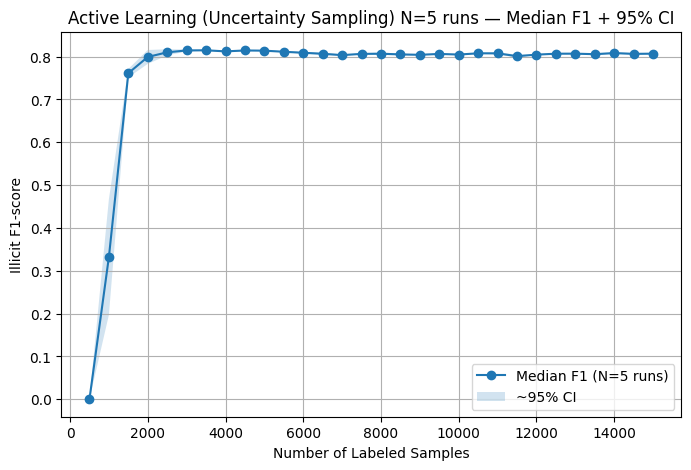


=== Run 5/5, Random State 20

===== Warm-up stage: Isolation Forest =====
Warm-up selected 1500 samples.
Warm-up found 2 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 5] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 5] XGBoost_Model_02 illicit F1-score: 0.5158
[Run 5] XGBoost_Model_03 illicit F1-score: 0.7754
[Run 5] XGBoost_Model_04 illicit F1-score: 0.8016
[Run 5] XGBoost_Model_05 illicit F1-score: 0.8077
[Run 5] XGBoost_Model_06 illicit F1-score: 0.8188
[Run 5] XGBoost_Model_07 illicit F1-score: 0.8167
[Run 5] XGBoost_Model_08 illicit F1-score: 0.8190
[Run 5] XGBoost_Model_09 illicit F1-score: 0.8131
[Run 5] XGBoost_Model_10 illicit F1-score: 0.8171
[Run 5] XGBoost_Model_11 illicit F1-score: 0.8082
[Run 5] XGBoost_Model_12 illicit F1-score: 0.8052
[Run 5] XGBoost_Model_13 illicit F1-score: 0.8060
[Run 5] XGBoost_Model_14 illicit F1-score: 0.8060
[Run 5] XGBoost_Model_15 illicit F1-score: 0.8058
[Run 5] XGBoost_Model_16 illicit F1-score: 0.8077
[Run 5] XGBoost_Model_17 illicit F1-score: 0.8041
[Run 5] XGBoost_Model_18 illicit F1-score: 0.8008
[Run 5] XGBoost_Model_19 illicit F1-score: 0.8035
[Run 5] XGBoost_Model_20 illicit F1-score: 0.8016


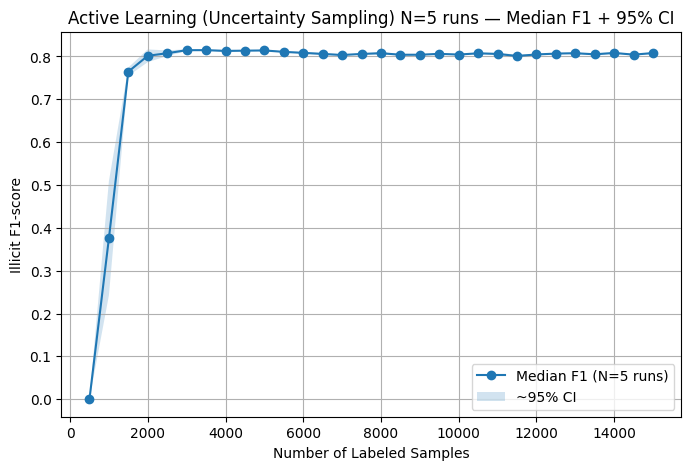


=== Run 1/5, Random State 42

===== Warm-up stage: Isolation Forest =====
Warm-up selected 2000 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 1] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_02 illicit F1-score: 0.6178
[Run 1] XGBoost_Model_03 illicit F1-score: 0.7640
[Run 1] XGBoost_Model_04 illicit F1-score: 0.8072
[Run 1] XGBoost_Model_05 illicit F1-score: 0.8184
[Run 1] XGBoost_Model_06 illicit F1-score: 0.8119
[Run 1] XGBoost_Model_07 illicit F1-score: 0.8087
[Run 1] XGBoost_Model_08 illicit F1-score: 0.8072
[Run 1] XGBoost_Model_09 illicit F1-score: 0.8035
[Run 1] XGBoost_Model_10 illicit F1-score: 0.8095
[Run 1] XGBoost_Model_11 illicit F1-score: 0.8023
[Run 1] XGBoost_Model_12 illicit F1-score: 0.8070
[Run 1] XGBoost_Model_13 illicit F1-score: 0.8008
[Run 1] XGBoost_Model_14 illicit F1-score: 0.8078
[Run 1] XGBoost_Model_15 illicit F1-score: 0.8064
[Run 1] XGBoost_Model_16 illicit F1-score: 0.8105
[Run 1] XGBoost_Model_17 illicit F1-score: 0.8107
[Run 1] XGBoost_Model_18 illicit F1-score: 0.8064
[Run 1] XGBoost_Model_19 illicit F1-score: 0.8079
[Run 1] XGBoost_Model_20 illicit F1-score: 0.8131


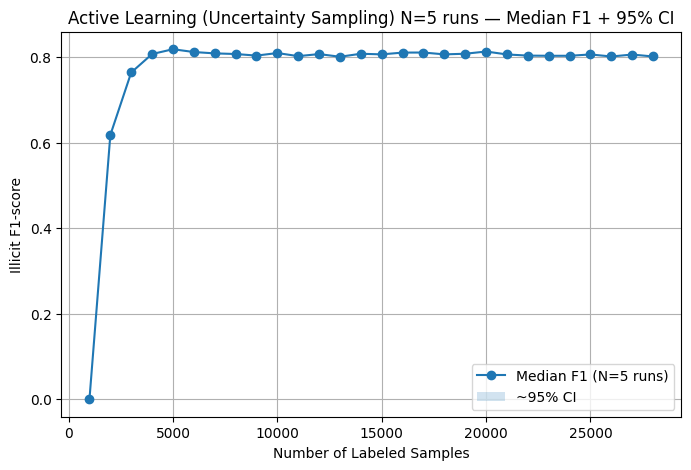


=== Run 2/5, Random State 100

===== Warm-up stage: Isolation Forest =====
Warm-up selected 3000 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 2] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 2] XGBoost_Model_02 illicit F1-score: 0.5659
[Run 2] XGBoost_Model_03 illicit F1-score: 0.7304
[Run 2] XGBoost_Model_04 illicit F1-score: 0.8070
[Run 2] XGBoost_Model_05 illicit F1-score: 0.8142
[Run 2] XGBoost_Model_06 illicit F1-score: 0.8104
[Run 2] XGBoost_Model_07 illicit F1-score: 0.8102
[Run 2] XGBoost_Model_08 illicit F1-score: 0.8129
[Run 2] XGBoost_Model_09 illicit F1-score: 0.8114
[Run 2] XGBoost_Model_10 illicit F1-score: 0.8101
[Run 2] XGBoost_Model_11 illicit F1-score: 0.8052
[Run 2] XGBoost_Model_12 illicit F1-score: 0.8053
[Run 2] XGBoost_Model_13 illicit F1-score: 0.8043
[Run 2] XGBoost_Model_14 illicit F1-score: 0.8091
[Run 2] XGBoost_Model_15 illicit F1-score: 0.8035
[Run 2] XGBoost_Model_16 illicit F1-score: 0.8052
[Run 2] XGBoost_Model_17 illicit F1-score: 0.8076
[Run 2] XGBoost_Model_18 illicit F1-score: 0.8072
[Run 2] XGBoost_Model_19 illicit F1-score: 0.8021
[Run 2] XGBoost_Model_20 illicit F1-score: 0.8041


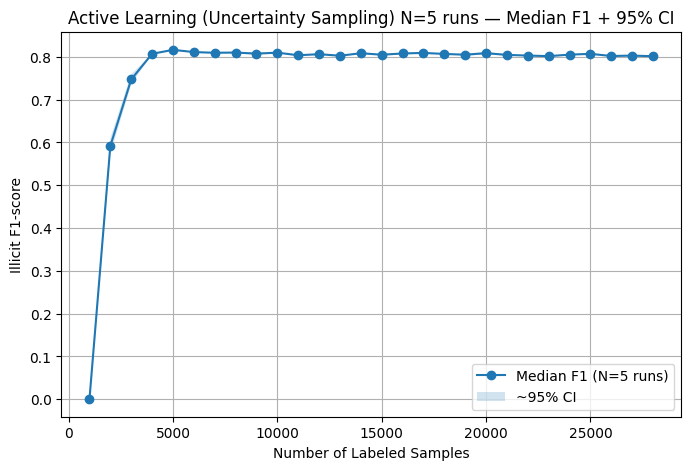


=== Run 3/5, Random State 1

===== Warm-up stage: Isolation Forest =====
Warm-up selected 3000 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 3] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 3] XGBoost_Model_02 illicit F1-score: 0.2624
[Run 3] XGBoost_Model_03 illicit F1-score: 0.7039
[Run 3] XGBoost_Model_04 illicit F1-score: 0.8159
[Run 3] XGBoost_Model_05 illicit F1-score: 0.8125
[Run 3] XGBoost_Model_06 illicit F1-score: 0.8087
[Run 3] XGBoost_Model_07 illicit F1-score: 0.8159
[Run 3] XGBoost_Model_08 illicit F1-score: 0.8064
[Run 3] XGBoost_Model_09 illicit F1-score: 0.8068
[Run 3] XGBoost_Model_10 illicit F1-score: 0.8084
[Run 3] XGBoost_Model_11 illicit F1-score: 0.8049
[Run 3] XGBoost_Model_12 illicit F1-score: 0.8080
[Run 3] XGBoost_Model_13 illicit F1-score: 0.8060
[Run 3] XGBoost_Model_14 illicit F1-score: 0.8051
[Run 3] XGBoost_Model_15 illicit F1-score: 0.8053
[Run 3] XGBoost_Model_16 illicit F1-score: 0.8095
[Run 3] XGBoost_Model_17 illicit F1-score: 0.8037
[Run 3] XGBoost_Model_18 illicit F1-score: 0.8064
[Run 3] XGBoost_Model_19 illicit F1-score: 0.8073
[Run 3] XGBoost_Model_20 illicit F1-score: 0.8060


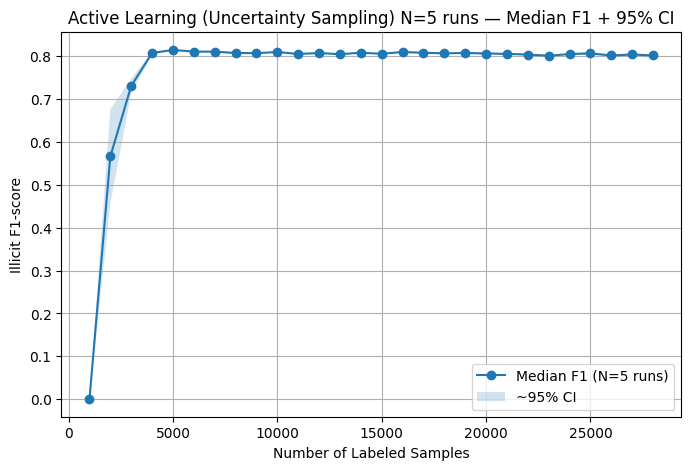


=== Run 4/5, Random State 10

===== Warm-up stage: Isolation Forest =====
Warm-up selected 3000 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 4] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 4] XGBoost_Model_02 illicit F1-score: 0.4723
[Run 4] XGBoost_Model_03 illicit F1-score: 0.7591
[Run 4] XGBoost_Model_04 illicit F1-score: 0.8045
[Run 4] XGBoost_Model_05 illicit F1-score: 0.8114
[Run 4] XGBoost_Model_06 illicit F1-score: 0.8114
[Run 4] XGBoost_Model_07 illicit F1-score: 0.8122
[Run 4] XGBoost_Model_08 illicit F1-score: 0.8021
[Run 4] XGBoost_Model_09 illicit F1-score: 0.8018
[Run 4] XGBoost_Model_10 illicit F1-score: 0.8074
[Run 4] XGBoost_Model_11 illicit F1-score: 0.8068
[Run 4] XGBoost_Model_12 illicit F1-score: 0.8037
[Run 4] XGBoost_Model_13 illicit F1-score: 0.8016
[Run 4] XGBoost_Model_14 illicit F1-score: 0.8058
[Run 4] XGBoost_Model_15 illicit F1-score: 0.8012
[Run 4] XGBoost_Model_16 illicit F1-score: 0.8131
[Run 4] XGBoost_Model_17 illicit F1-score: 0.8075
[Run 4] XGBoost_Model_18 illicit F1-score: 0.8132
[Run 4] XGBoost_Model_19 illicit F1-score: 0.8097
[Run 4] XGBoost_Model_20 illicit F1-score: 0.8002


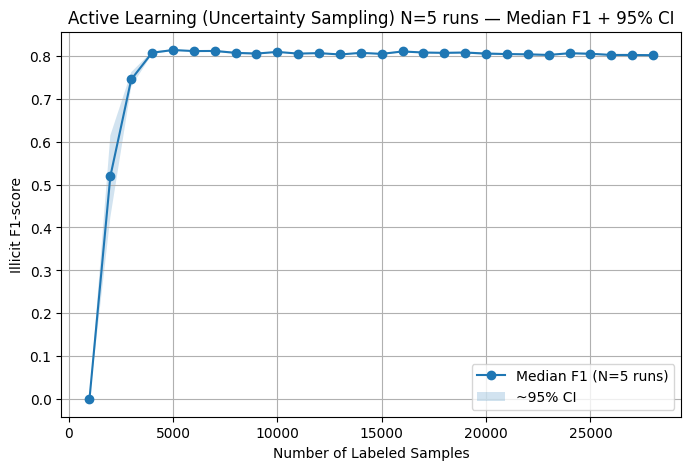


=== Run 5/5, Random State 20

===== Warm-up stage: Isolation Forest =====
Warm-up selected 2000 samples.
Warm-up found 2 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 5] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 5] XGBoost_Model_02 illicit F1-score: 0.6756
[Run 5] XGBoost_Model_03 illicit F1-score: 0.8016
[Run 5] XGBoost_Model_04 illicit F1-score: 0.8118
[Run 5] XGBoost_Model_05 illicit F1-score: 0.8163
[Run 5] XGBoost_Model_06 illicit F1-score: 0.8150
[Run 5] XGBoost_Model_07 illicit F1-score: 0.8110
[Run 5] XGBoost_Model_08 illicit F1-score: 0.8133
[Run 5] XGBoost_Model_09 illicit F1-score: 0.8135
[Run 5] XGBoost_Model_10 illicit F1-score: 0.8068
[Run 5] XGBoost_Model_11 illicit F1-score: 0.8089
[Run 5] XGBoost_Model_12 illicit F1-score: 0.8045
[Run 5] XGBoost_Model_13 illicit F1-score: 0.8057
[Run 5] XGBoost_Model_14 illicit F1-score: 0.8043
[Run 5] XGBoost_Model_15 illicit F1-score: 0.8014
[Run 5] XGBoost_Model_16 illicit F1-score: 0.8074
[Run 5] XGBoost_Model_17 illicit F1-score: 0.8041
[Run 5] XGBoost_Model_18 illicit F1-score: 0.8029
[Run 5] XGBoost_Model_19 illicit F1-score: 0.8087
[Run 5] XGBoost_Model_20 illicit F1-score: 0.8089


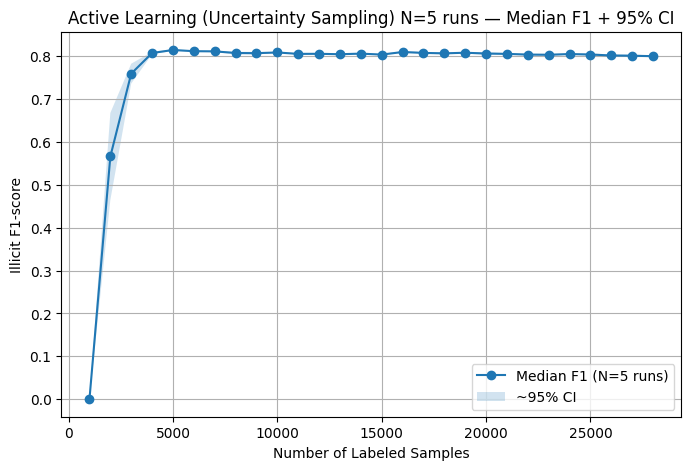


=== Run 1/5, Random State 42

===== Warm-up stage: Isolation Forest =====
Warm-up selected 1500 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 1] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_02 illicit F1-score: 0.6726
[Run 1] XGBoost_Model_03 illicit F1-score: 0.7842
[Run 1] XGBoost_Model_04 illicit F1-score: 0.8035
[Run 1] XGBoost_Model_05 illicit F1-score: 0.8159
[Run 1] XGBoost_Model_06 illicit F1-score: 0.8145
[Run 1] XGBoost_Model_07 illicit F1-score: 0.8049
[Run 1] XGBoost_Model_08 illicit F1-score: 0.8132
[Run 1] XGBoost_Model_09 illicit F1-score: 0.8082
[Run 1] XGBoost_Model_10 illicit F1-score: 0.8111
[Run 1] XGBoost_Model_11 illicit F1-score: 0.8086
[Run 1] XGBoost_Model_12 illicit F1-score: 0.8051
[Run 1] XGBoost_Model_13 illicit F1-score: 0.8047
[Run 1] XGBoost_Model_14 illicit F1-score: 0.8047
[Run 1] XGBoost_Model_15 illicit F1-score: 0.8081
[Run 1] XGBoost_Model_16 illicit F1-score: 0.8074
[Run 1] XGBoost_Model_17 illicit F1-score: 0.7969
[Run 1] XGBoost_Model_18 illicit F1-score: 0.8074
[Run 1] XGBoost_Model_19 illicit F1-score: 0.7990

===== Mean F1-score across 5 runs per cycle =====

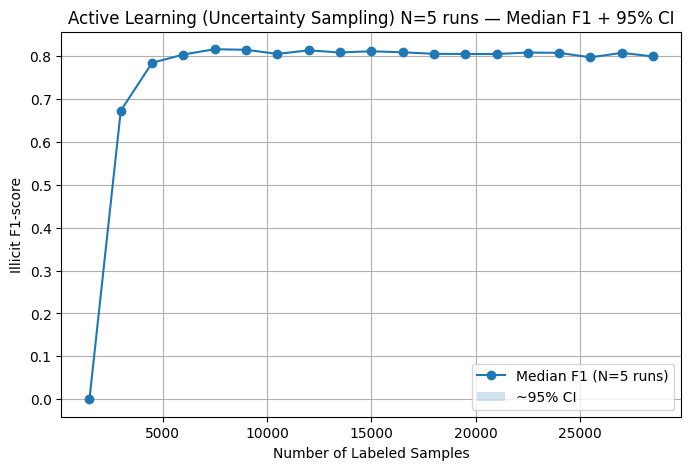


=== Run 2/5, Random State 100

===== Warm-up stage: Isolation Forest =====
Warm-up selected 3000 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 2] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 2] XGBoost_Model_02 illicit F1-score: 0.6445
[Run 2] XGBoost_Model_03 illicit F1-score: 0.8068
[Run 2] XGBoost_Model_04 illicit F1-score: 0.8097
[Run 2] XGBoost_Model_05 illicit F1-score: 0.8144
[Run 2] XGBoost_Model_06 illicit F1-score: 0.8119
[Run 2] XGBoost_Model_07 illicit F1-score: 0.8045
[Run 2] XGBoost_Model_08 illicit F1-score: 0.8087
[Run 2] XGBoost_Model_09 illicit F1-score: 0.8080
[Run 2] XGBoost_Model_10 illicit F1-score: 0.8120
[Run 2] XGBoost_Model_11 illicit F1-score: 0.8110
[Run 2] XGBoost_Model_12 illicit F1-score: 0.8118
[Run 2] XGBoost_Model_13 illicit F1-score: 0.8025
[Run 2] XGBoost_Model_14 illicit F1-score: 0.8033
[Run 2] XGBoost_Model_15 illicit F1-score: 0.8116
[Run 2] XGBoost_Model_16 illicit F1-score: 0.8089
[Run 2] XGBoost_Model_17 illicit F1-score: 0.8056
[Run 2] XGBoost_Model_18 illicit F1-score: 0.7973

===== Mean F1-score across 5 runs per cycle =====
Cycle 01, Labeled 1500 samples: Mean F1 = 0.0000


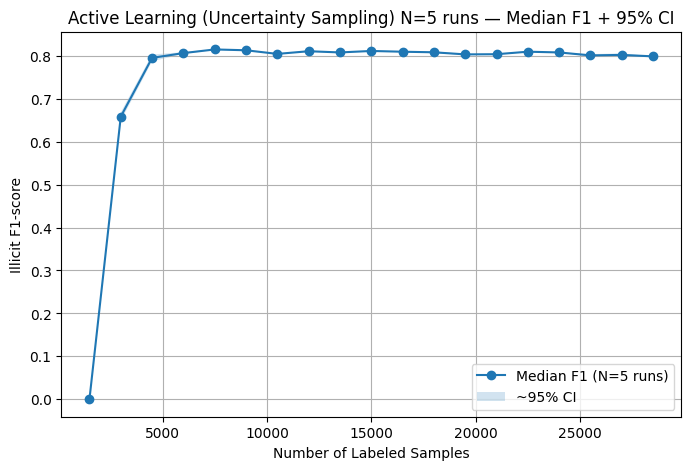


=== Run 3/5, Random State 1

===== Warm-up stage: Isolation Forest =====
Warm-up selected 3000 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 3] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 3] XGBoost_Model_02 illicit F1-score: 0.5966
[Run 3] XGBoost_Model_03 illicit F1-score: 0.7921
[Run 3] XGBoost_Model_04 illicit F1-score: 0.8060
[Run 3] XGBoost_Model_05 illicit F1-score: 0.8079
[Run 3] XGBoost_Model_06 illicit F1-score: 0.8066
[Run 3] XGBoost_Model_07 illicit F1-score: 0.8072
[Run 3] XGBoost_Model_08 illicit F1-score: 0.8112
[Run 3] XGBoost_Model_09 illicit F1-score: 0.8045
[Run 3] XGBoost_Model_10 illicit F1-score: 0.8097
[Run 3] XGBoost_Model_11 illicit F1-score: 0.8097
[Run 3] XGBoost_Model_12 illicit F1-score: 0.7988
[Run 3] XGBoost_Model_13 illicit F1-score: 0.8039
[Run 3] XGBoost_Model_14 illicit F1-score: 0.8045
[Run 3] XGBoost_Model_15 illicit F1-score: 0.8099
[Run 3] XGBoost_Model_16 illicit F1-score: 0.8043
[Run 3] XGBoost_Model_17 illicit F1-score: 0.8045
[Run 3] XGBoost_Model_18 illicit F1-score: 0.8033

===== Mean F1-score across 5 runs per cycle =====
Cycle 01, Labeled 1500 samples: Mean F1 = 0.0000


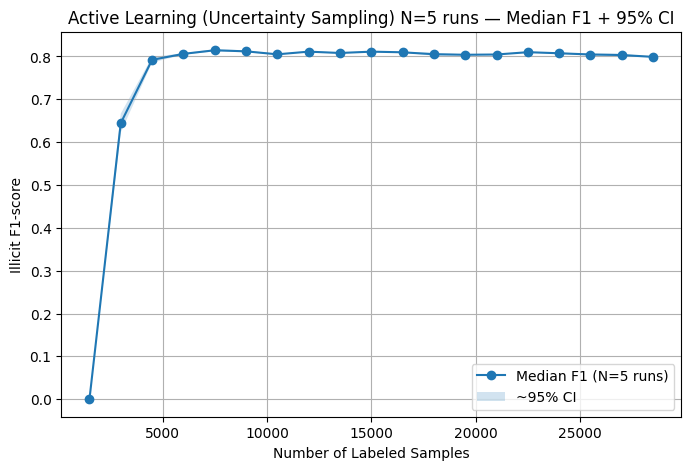


=== Run 4/5, Random State 10

===== Warm-up stage: Isolation Forest =====
Warm-up selected 3000 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 4] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 4] XGBoost_Model_02 illicit F1-score: 0.4944
[Run 4] XGBoost_Model_03 illicit F1-score: 0.7884
[Run 4] XGBoost_Model_04 illicit F1-score: 0.8066
[Run 4] XGBoost_Model_05 illicit F1-score: 0.8122
[Run 4] XGBoost_Model_06 illicit F1-score: 0.8025
[Run 4] XGBoost_Model_07 illicit F1-score: 0.8060
[Run 4] XGBoost_Model_08 illicit F1-score: 0.8045
[Run 4] XGBoost_Model_09 illicit F1-score: 0.8105
[Run 4] XGBoost_Model_10 illicit F1-score: 0.8051
[Run 4] XGBoost_Model_11 illicit F1-score: 0.8160
[Run 4] XGBoost_Model_12 illicit F1-score: 0.8074
[Run 4] XGBoost_Model_13 illicit F1-score: 0.8097
[Run 4] XGBoost_Model_14 illicit F1-score: 0.8058
[Run 4] XGBoost_Model_15 illicit F1-score: 0.8062
[Run 4] XGBoost_Model_16 illicit F1-score: 0.7988
[Run 4] XGBoost_Model_17 illicit F1-score: 0.8084
[Run 4] XGBoost_Model_18 illicit F1-score: 0.8016

===== Mean F1-score across 5 runs per cycle =====
Cycle 01, Labeled 1500 samples: Mean F1 = 0.0000


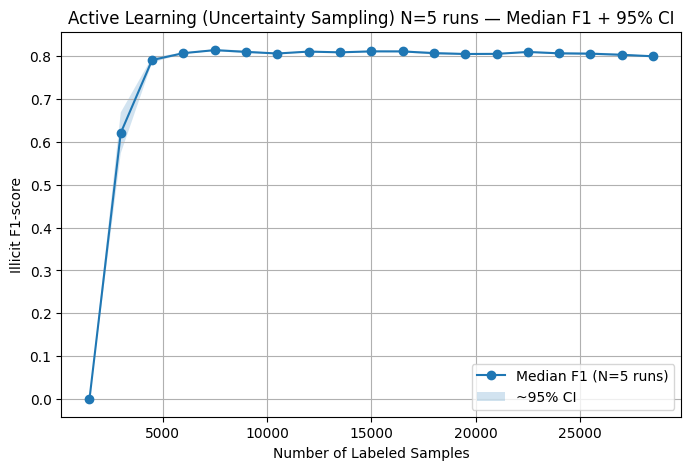


=== Run 5/5, Random State 20

===== Warm-up stage: Isolation Forest =====
Warm-up selected 1500 samples.
Warm-up found 2 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 5] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 5] XGBoost_Model_02 illicit F1-score: 0.6474
[Run 5] XGBoost_Model_03 illicit F1-score: 0.7794
[Run 5] XGBoost_Model_04 illicit F1-score: 0.8091
[Run 5] XGBoost_Model_05 illicit F1-score: 0.8148
[Run 5] XGBoost_Model_06 illicit F1-score: 0.8150
[Run 5] XGBoost_Model_07 illicit F1-score: 0.8021
[Run 5] XGBoost_Model_08 illicit F1-score: 0.8041
[Run 5] XGBoost_Model_09 illicit F1-score: 0.8082
[Run 5] XGBoost_Model_10 illicit F1-score: 0.8091
[Run 5] XGBoost_Model_11 illicit F1-score: 0.8101
[Run 5] XGBoost_Model_12 illicit F1-score: 0.8103
[Run 5] XGBoost_Model_13 illicit F1-score: 0.8079
[Run 5] XGBoost_Model_14 illicit F1-score: 0.8052
[Run 5] XGBoost_Model_15 illicit F1-score: 0.8039
[Run 5] XGBoost_Model_16 illicit F1-score: 0.8091
[Run 5] XGBoost_Model_17 illicit F1-score: 0.8057
[Run 5] XGBoost_Model_18 illicit F1-score: 0.8043
[Run 5] XGBoost_Model_19 illicit F1-score: 0.8018

===== Mean F1-score across 5 runs per cycle =====

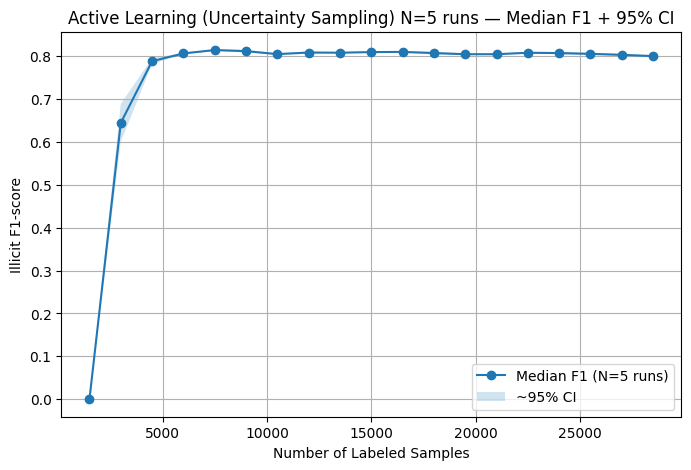


=== Run 1/5, Random State 42

===== Warm-up stage: Isolation Forest =====
Warm-up selected 2000 samples.
Warm-up found 1 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 1] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 1] XGBoost_Model_02 illicit F1-score: 0.7199
[Run 1] XGBoost_Model_03 illicit F1-score: 0.8061
[Run 1] XGBoost_Model_04 illicit F1-score: 0.8083
[Run 1] XGBoost_Model_05 illicit F1-score: 0.8062
[Run 1] XGBoost_Model_06 illicit F1-score: 0.8101
[Run 1] XGBoost_Model_07 illicit F1-score: 0.8060
[Run 1] XGBoost_Model_08 illicit F1-score: 0.8137
[Run 1] XGBoost_Model_09 illicit F1-score: 0.8084
[Run 1] XGBoost_Model_10 illicit F1-score: 0.8051
[Run 1] XGBoost_Model_11 illicit F1-score: 0.8079
[Run 1] XGBoost_Model_12 illicit F1-score: 0.8045
[Run 1] XGBoost_Model_13 illicit F1-score: 0.7994
[Run 1] XGBoost_Model_14 illicit F1-score: 0.7965

===== Mean F1-score across 5 runs per cycle =====
Cycle 01, Labeled 2000 samples: Mean F1 = 0.0000
Cycle 02, Labeled 4000 samples: Mean F1 = 0.7199
Cycle 03, Labeled 6000 samples: Mean F1 = 0.8061
Cycle 04, Labeled 8000 samples: Mean F1 = 0.8083
Cycle 05, Labeled 10000 samples: Mean F1 = 0.8062
Cyc

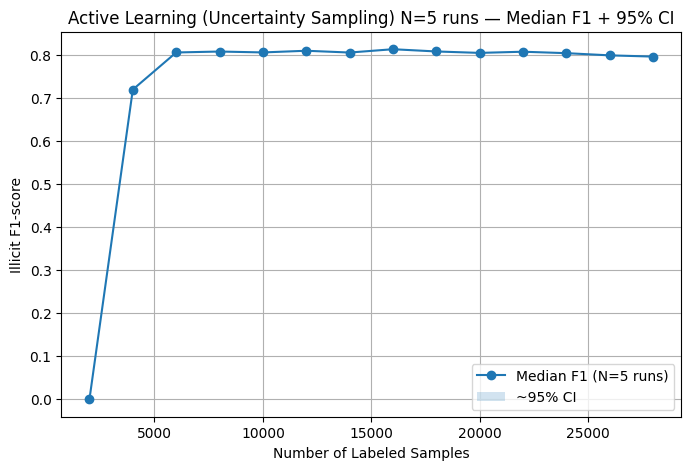


=== Run 2/5, Random State 100

===== Warm-up stage: Isolation Forest =====
Warm-up selected 4000 samples.
Warm-up found 2 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 2] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 2] XGBoost_Model_02 illicit F1-score: 0.6261
[Run 2] XGBoost_Model_03 illicit F1-score: 0.7896
[Run 2] XGBoost_Model_04 illicit F1-score: 0.8146
[Run 2] XGBoost_Model_05 illicit F1-score: 0.8077
[Run 2] XGBoost_Model_06 illicit F1-score: 0.8116
[Run 2] XGBoost_Model_07 illicit F1-score: 0.8033
[Run 2] XGBoost_Model_08 illicit F1-score: 0.8106
[Run 2] XGBoost_Model_09 illicit F1-score: 0.8050
[Run 2] XGBoost_Model_10 illicit F1-score: 0.8062
[Run 2] XGBoost_Model_11 illicit F1-score: 0.8020
[Run 2] XGBoost_Model_12 illicit F1-score: 0.8064
[Run 2] XGBoost_Model_13 illicit F1-score: 0.7982

===== Mean F1-score across 5 runs per cycle =====
Cycle 01, Labeled 2000 samples: Mean F1 = 0.0000
Cycle 02, Labeled 4000 samples: Mean F1 = 0.6730
Cycle 03, Labeled 6000 samples: Mean F1 = 0.7979
Cycle 04, Labeled 8000 samples: Mean F1 = 0.8115
Cycle 05, Labeled 10000 samples: Mean F1 = 0.8069
Cycle 06, Labeled 12000 samples: Mean F1 = 0.8109
Cyc

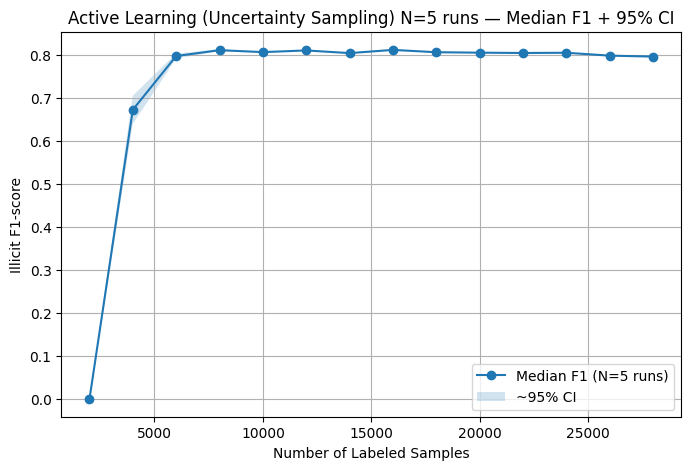


=== Run 3/5, Random State 1

===== Warm-up stage: Isolation Forest =====
Warm-up selected 4000 samples.
Warm-up found 2 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 3] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 3] XGBoost_Model_02 illicit F1-score: 0.7630
[Run 3] XGBoost_Model_03 illicit F1-score: 0.8083
[Run 3] XGBoost_Model_04 illicit F1-score: 0.8175
[Run 3] XGBoost_Model_05 illicit F1-score: 0.8054
[Run 3] XGBoost_Model_06 illicit F1-score: 0.8139
[Run 3] XGBoost_Model_07 illicit F1-score: 0.8056
[Run 3] XGBoost_Model_08 illicit F1-score: 0.8095
[Run 3] XGBoost_Model_09 illicit F1-score: 0.8058
[Run 3] XGBoost_Model_10 illicit F1-score: 0.8060
[Run 3] XGBoost_Model_11 illicit F1-score: 0.8008
[Run 3] XGBoost_Model_12 illicit F1-score: 0.8126
[Run 3] XGBoost_Model_13 illicit F1-score: 0.7953

===== Mean F1-score across 5 runs per cycle =====
Cycle 01, Labeled 2000 samples: Mean F1 = 0.0000
Cycle 02, Labeled 4000 samples: Mean F1 = 0.7030
Cycle 03, Labeled 6000 samples: Mean F1 = 0.8013
Cycle 04, Labeled 8000 samples: Mean F1 = 0.8135
Cycle 05, Labeled 10000 samples: Mean F1 = 0.8064
Cycle 06, Labeled 12000 samples: Mean F1 = 0.8119
Cyc

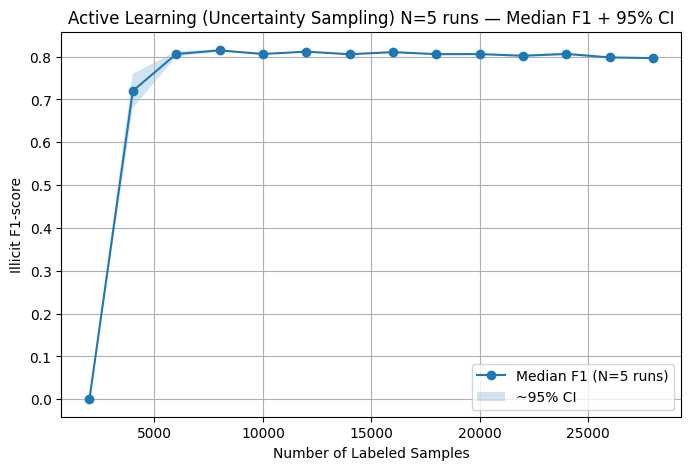


=== Run 4/5, Random State 10

===== Warm-up stage: Isolation Forest =====
Warm-up selected 4000 samples.
Warm-up found 2 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 4] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 4] XGBoost_Model_02 illicit F1-score: 0.6368
[Run 4] XGBoost_Model_03 illicit F1-score: 0.7792
[Run 4] XGBoost_Model_04 illicit F1-score: 0.8129
[Run 4] XGBoost_Model_05 illicit F1-score: 0.8104
[Run 4] XGBoost_Model_06 illicit F1-score: 0.8072
[Run 4] XGBoost_Model_07 illicit F1-score: 0.8062
[Run 4] XGBoost_Model_08 illicit F1-score: 0.8056
[Run 4] XGBoost_Model_09 illicit F1-score: 0.8074
[Run 4] XGBoost_Model_10 illicit F1-score: 0.8020
[Run 4] XGBoost_Model_11 illicit F1-score: 0.8033
[Run 4] XGBoost_Model_12 illicit F1-score: 0.8068
[Run 4] XGBoost_Model_13 illicit F1-score: 0.7982

===== Mean F1-score across 5 runs per cycle =====
Cycle 01, Labeled 2000 samples: Mean F1 = 0.0000
Cycle 02, Labeled 4000 samples: Mean F1 = 0.6864
Cycle 03, Labeled 6000 samples: Mean F1 = 0.7958
Cycle 04, Labeled 8000 samples: Mean F1 = 0.8133
Cycle 05, Labeled 10000 samples: Mean F1 = 0.8074
Cycle 06, Labeled 12000 samples: Mean F1 = 0.8107
Cyc

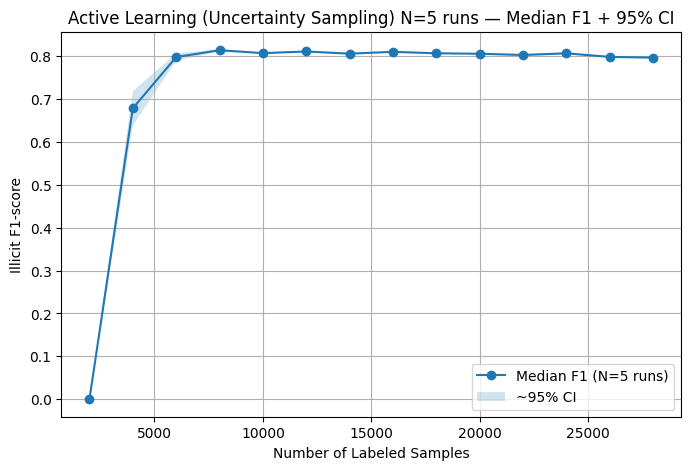


=== Run 5/5, Random State 20

===== Warm-up stage: Isolation Forest =====
Warm-up selected 2000 samples.
Warm-up found 2 illicit samples.

===== Active Learning loop: Uncertainty Sampling =====


/var/folders/2v/617m0pq96qq942zr8nbfyzch0000gn/T/ipykernel_21374/4079194343.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 5] XGBoost_Model_01 illicit F1-score: 0.0000
[Run 5] XGBoost_Model_02 illicit F1-score: 0.7096
[Run 5] XGBoost_Model_03 illicit F1-score: 0.8072
[Run 5] XGBoost_Model_04 illicit F1-score: 0.8079
[Run 5] XGBoost_Model_05 illicit F1-score: 0.8114
[Run 5] XGBoost_Model_06 illicit F1-score: 0.8099
[Run 5] XGBoost_Model_07 illicit F1-score: 0.8118
[Run 5] XGBoost_Model_08 illicit F1-score: 0.8079
[Run 5] XGBoost_Model_09 illicit F1-score: 0.8097
[Run 5] XGBoost_Model_10 illicit F1-score: 0.8087
[Run 5] XGBoost_Model_11 illicit F1-score: 0.8016
[Run 5] XGBoost_Model_12 illicit F1-score: 0.8082
[Run 5] XGBoost_Model_13 illicit F1-score: 0.8037
[Run 5] XGBoost_Model_14 illicit F1-score: 0.7935

===== Mean F1-score across 5 runs per cycle =====
Cycle 01, Labeled 2000 samples: Mean F1 = 0.0000
Cycle 02, Labeled 4000 samples: Mean F1 = 0.6911
Cycle 03, Labeled 6000 samples: Mean F1 = 0.7981
Cycle 04, Labeled 8000 samples: Mean F1 = 0.8122
Cycle 05, Labeled 10000 samples: Mean F1 = 0.8082
Cyc

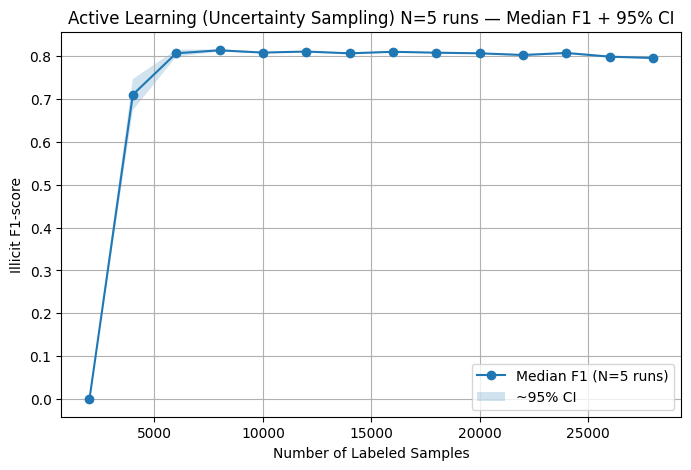


===== Batch Size Results Summary =====
Batch Size 200:
  Median F1: 0.8052
  95% CI: 0.0020
  Mean F1: 0.8061
Batch Size 500:
  Median F1: 0.8080
  95% CI: 0.0018
  Mean F1: 0.8075
Batch Size 1000:
  Median F1: 0.7998
  95% CI: 0.0011
  Mean F1: 0.7998
Batch Size 1500:
  Median F1: 0.8004
  95% CI: 0.0010
  Mean F1: 0.8004
Batch Size 2000:
  Median F1: 0.7950
  95% CI: 0.0011
  Mean F1: 0.7950


In [49]:
# --- Active Learning: IF + Uncertainty Sampling + XGBoost ---
# Paper reproduction version: N=5 runs, median F1 + 95% CI

import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import xgboost as xgb
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Step 1: Load labeled data
labeled_df = pd.read_csv('data/elliptic_txs_features_labeled.csv')

# Check data
print("Loaded labeled CSV rows:", labeled_df.shape[0])
print("Unique time_steps:", sorted(labeled_df['time_step'].unique()))
print("Label distribution:\n", labeled_df['class'].value_counts())

# Step 3: Split train/test by time_step
train_df = labeled_df[labeled_df['time_step'] <= 34].reset_index(drop=True)
test_df  = labeled_df[labeled_df['time_step'] >= 35].reset_index(drop=True)

# Prepare test set
X_test = test_df.drop(columns=['txId', 'time_step', 'class'])
y_test = (test_df['class'] == 1).astype(int)

# Feature columns
feature_columns = [col for col in train_df.columns if col.startswith('feature_') or col.startswith('f')]

# Config
max_iterations = 30  # 30 iterations = up to 1500 samples
N_runs = len(SEEDS)  # Number of runs based on seeds

batch_size_scores = {}
# Step 4: Repeat N=5 runs
for batch_size in batch_sizes:
    all_f1_scores = []
    for run in range(N_runs):
        seed = SEEDS[run]
        print(f"\n==========================")
        print(f"=== Run {run+1}/{N_runs}, Random State {seed}")
        print("==========================")
        
        # Initialize pools
        unlabeled_pool = train_df.copy()
        labeled_pool = pd.DataFrame(columns=train_df.columns)
        f1_scores = []
        
        # Warm-up using Isolation Forest
        print("\n===== Warm-up stage: Isolation Forest =====")
        iso_forest = IsolationForest(random_state=seed)
        iso_forest.fit(unlabeled_pool[feature_columns])
        anomaly_scores = -iso_forest.score_samples(unlabeled_pool[feature_columns])
        unlabeled_pool['anomaly_score'] = anomaly_scores
        unlabeled_pool = unlabeled_pool.sort_values(by='anomaly_score', ascending=False).reset_index(drop=True)
        
        found_illicit = False
        pointer = 0
        warmup_illicit = 0
        
        while not found_illicit and pointer < len(unlabeled_pool):
            batch = unlabeled_pool.iloc[pointer:pointer+batch_size]
            labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)
            pointer += batch_size
            warmup_illicit = (labeled_pool['class'] == 1).sum()
            found_illicit = warmup_illicit > 0
        
        print(f"Warm-up selected {len(labeled_pool)} samples.")
        print(f"Warm-up found {warmup_illicit} illicit samples.")
        
        # Remove warm-up samples
        unlabeled_pool = unlabeled_pool.iloc[pointer:].drop(columns='anomaly_score').reset_index(drop=True)
        
        # Active Learning loop
        iteration = 1
        print("\n===== Active Learning loop: Uncertainty Sampling =====")
        
        while len(unlabeled_pool) > 0 and iteration <= max_iterations:
            X_train = labeled_pool[feature_columns]
            y_train = (labeled_pool['class'] == 1).astype(int)
            
            xgb_clf = xgb.XGBClassifier(
                tree_method='hist',
                eval_metric='logloss',
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                random_state=seed
            )
            
            xgb_clf.fit(X_train, y_train)
            
            y_pred = xgb_clf.predict(X_test)
            f1 = f1_score(y_test, y_pred, pos_label=1)
            f1_scores.append(f1)
            print(f"[Run {run+1}] XGBoost_Model_{iteration:02d} illicit F1-score: {f1:.4f}")
            
            # Uncertainty sampling
            X_unlabeled = unlabeled_pool[feature_columns]
            proba = xgb_clf.predict_proba(X_unlabeled)[:, 1]
            uncertainty = np.abs(proba - 0.5)
            
            select_idx = np.argsort(uncertainty)[:batch_size]
            new_batch = unlabeled_pool.iloc[select_idx]
            
            labeled_pool = pd.concat([labeled_pool, new_batch], ignore_index=True)
            unlabeled_pool = unlabeled_pool.drop(unlabeled_pool.index[select_idx]).reset_index(drop=True)
            
            iteration += 1
        
        # Save F1-scores of this run
        all_f1_scores.append(f1_scores)

        # Step 5: Aggregate results — median + 95% CI
        # Pad runs with np.nan to same length
        max_len = max(len(scores) for scores in all_f1_scores)
        f1_matrix = np.full((N_runs, max_len), np.nan)
        for i, scores in enumerate(all_f1_scores):
            f1_matrix[i, :len(scores)] = scores


        # Step 5b: Print Mean F1-score across 5 runs per cycle
        mean_f1 = np.nanmean(f1_matrix, axis=0)

        print("\n===== Mean F1-score across 5 runs per cycle =====")
        for i, f1 in enumerate(mean_f1):
            print(f"Cycle {i+1:02d}, Labeled {(i+1)*batch_size} samples: Mean F1 = {f1:.4f}")


        # Median & CI
        median_f1 = np.nanmedian(f1_matrix, axis=0)
        std_f1 = np.nanstd(f1_matrix, axis=0)
        ci_95 = 1.57 * std_f1 / np.sqrt(N_runs)  # Approx 95% CI

        # Step 6: Plot
        x_axis = np.arange(1, len(median_f1)+1) * batch_size

        plt.figure(figsize=(8, 5))
        plt.plot(x_axis, median_f1, marker='o', label='Median F1 (N=5 runs)')
        plt.fill_between(x_axis, median_f1 - ci_95, median_f1 + ci_95, alpha=0.2, label='~95% CI')
        plt.title("Active Learning (Uncertainty Sampling) N=5 runs — Median F1 + 95% CI")
        plt.xlabel("Number of Labeled Samples")
        plt.ylabel("Illicit F1-score")
        plt.legend()
        plt.grid(True)
        plt.show()

    # Store results for this batch size
    batch_size_scores[batch_size] = {
        'median_f1': median_f1,
        'ci_95': ci_95,
        'mean_f1': mean_f1
    }
    
print("\n===== Batch Size Results Summary =====")
for batch_size, scores in batch_size_scores.items():
    print(f"Batch Size {batch_size}:")
    print(f"  Median F1: {scores['median_f1'][-1]:.4f}")
    print(f"  95% CI: {scores['ci_95'][-1]:.4f}")
    print(f"  Mean F1: {scores['mean_f1'][-1]:.4f}")

In [52]:
# Save the F1 matrix for future reference

import json

with open('results.json', 'r') as f:
    json_input = json.load(f)
    
json_input["IF + Uncertainty Sampling + XGBoost"] = {}
for k, v in batch_size_scores.items():
    json_input["IF + Uncertainty Sampling + XGBoost"][str(k)] = v['mean_f1'][-1]
    
with open('results.json', 'w') as f:
    json.dump(json_input, f, indent=4)